In [ ]:
# 전체코드: ResNet18 + CBAM + 데이터 증강 + Bounding Box 기반 MGA 준비 버전 (MGA Loss 포함) 
# CenterCrop / RandomAffine / RandomHorizontalFlip / RandomErasing

import os, re, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from glob import glob
from tqdm import tqdm
import pandas as pd
import cv2
import gc
from torchvision.transforms import v2

# 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 설정
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"

batch_size = 16
num_epochs = 100
learning_rate = 1e-4
lambda_mga = 0.5

# Transform
prep_tr = [
    v2.Lambda(lambda x: torch.clamp(x, -1000, 400)),
    v2.Lambda(lambda x: (x + 1000) / 1400),
    v2.CenterCrop((384, 384))
]
aug_tr = [
    v2.RandomAffine(degrees=10),
    v2.RandomHorizontalFlip(),
]
train_transform = v2.Compose(prep_tr + aug_tr + [
    v2.Normalize([0.5], [0.5]),
    v2.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0),
])
val_transform = v2.Compose(prep_tr + [v2.Normalize([0.5], [0.5])])

# Bounding box → mask
def create_binary_mask_from_bbox(bbox_list, image_size=(224, 224)):
    masks = []
    for bbox in bbox_list:
        mask = np.zeros(image_size, dtype=np.float32)
        x_min, y_min, x_max, y_max = bbox
        mask[y_min:y_max, x_min:x_max] = 1.0
        masks.append(mask)
    masks = np.stack(masks)
    masks = np.expand_dims(masks, axis=1)
    return torch.tensor(masks, dtype=torch.float32)

def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']
        slice_str = row['slice']
        slice_idx = int(re.findall(r'\d+', str(slice_str))[0])
        fname = f"{pid}_slice{slice_idx:03d}.npy"
        bbox = eval(row['bb'])
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

bbox_dict = load_bbox_dict(bbox_csv_path)

# 라벨 추출
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except: return None

# Dataset
class CTDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        fname = os.path.basename(path)

        img = np.load(path).astype(np.float32)
        img = torch.tensor(img).unsqueeze(0)  # [1, H, W]

        if self.transform:
            img = self.transform(img)

        if fname in bbox_dict:
            mask = create_binary_mask_from_bbox(bbox_dict[fname], image_size=(224, 224))
        else:
            mask = torch.zeros((1, 224, 224), dtype=torch.float32)

        return img, torch.tensor(label).long(), mask.squeeze(0)

    def __len__(self): return len(self.paths)

# CBAM (MGA 포함)
class ChannelAttention(nn.Module):
    def __init__(self, planes, ratio=16):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(planes, planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(planes // ratio, planes, 1, bias=False)
        )
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.max = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.shared(self.avg(x)) + self.shared(self.max(x)))

class SpatialAttention(nn.Module):
    def __init__(self, k=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=k // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_ = torch.max(x, dim=1, keepdim=True)[0]
        return self.sigmoid(self.conv(torch.cat([avg, max_], dim=1)))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()
        self.last_attention = None

    def forward(self, x):
        ca_out = self.ca(x) * x
        sa_out = self.sa(ca_out)
        self.last_attention = sa_out
        return sa_out * ca_out

# ResNet18 + CBAM
class BasicBlockCBAM(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None, use_cbam=True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.cbam = CBAM(out_planes) if use_cbam else None
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.cbam: out = self.cbam(out)
        if self.downsample: identity = self.downsample(x)
        return self.relu(out + identity)

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2, use_cbam=False)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1, use_cbam=True):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = [BasicBlockCBAM(self.in_planes, planes, stride, downsample, use_cbam)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlockCBAM(self.in_planes, planes, use_cbam=use_cbam))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))

# Run
def run():
    all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
    file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
    file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
    files, labels = zip(*file_label_pairs)
    train_files, temp_files, train_labels, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
    val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

    train_loader = DataLoader(CTDataset(train_files, train_labels, transform=train_transform), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(CTDataset(val_files, val_labels, transform=val_transform), batch_size=batch_size)
    test_loader = DataLoader(CTDataset(test_files, test_labels, transform=val_transform), batch_size=batch_size)

    model = ResNet18_CBAM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_acc = 0.0
    save_path = os.path.join(os.path.dirname(os.getcwd()), "pth", "aug_resnet_cbam_mga.pth")

    for epoch in range(num_epochs):
        model.train()
        correct = total = epoch_loss = 0
        for imaegs, labels, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            imaegs = imaegs.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            outputs = model(imaegs)
            ce_loss = criterion(outputs, labels)

            attn_map = model.layer3[1].cbam.last_attention

            if attn_map is not None:
                attn_map = F.interpolate(attn_map, size=(224, 224), mode='bilinear', align_corners=False).squeeze(1)
                attn_loss = F.mse_loss(attn_map, masks)
                loss = ce_loss + lambda_mga * attn_loss
            else:
                loss = ce_loss
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()

            total += labels.size(0)

        print(f"Train Acc: {(correct/total)*100:.2f}, Loss: {epoch_loss/len(train_loader):.4f}")

        torch.cuda.empty_cache()
        gc.collect()

        # Validation
        model.eval(); correct = total = 0
        with torch.no_grad():
            for imaegs, labels, masks in val_loader:
                imaegs = imaegs.to(device)
                labels = labels.to(device)

                outputs = model(imaegs)

                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print("✅ Saved best model!")

    # Test
    print("\n📊 Test Evaluation:")
    model.load_state_dict(torch.load(save_path)); model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for imaegs, labels, masks in test_loader:
            imaegs = imaegs.to(device)
            labels = labels.to(device)

            outputs = model(imaegs)

            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)

            y_probs.extend(probs.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    print(f"✅ Test Accuracy: {(np.array(y_pred) == np.array(y_true)).mean() * 100:.2f}%")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"AUC: {roc_auc_score(y_true, y_probs):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    run()

Using device: cuda:1


[Epoch 1]: 100%|██████████| 234/234 [00:24<00:00,  9.39it/s]


Train Acc: 65.51, Loss: 0.7105
Val Acc: 0.6825
✅ Saved best model!


[Epoch 2]: 100%|██████████| 234/234 [00:25<00:00,  9.27it/s]


Train Acc: 67.04, Loss: 0.6161
Val Acc: 0.6950
✅ Saved best model!


[Epoch 3]: 100%|██████████| 234/234 [00:35<00:00,  6.52it/s]


Train Acc: 68.22, Loss: 0.5976
Val Acc: 0.6925


[Epoch 4]: 100%|██████████| 234/234 [00:25<00:00,  9.16it/s]


Train Acc: 69.45, Loss: 0.5830
Val Acc: 0.6850


[Epoch 5]: 100%|██████████| 234/234 [00:25<00:00,  9.06it/s]


Train Acc: 70.53, Loss: 0.5761
Val Acc: 0.6937


[Epoch 6]: 100%|██████████| 234/234 [00:26<00:00,  8.73it/s]


Train Acc: 70.63, Loss: 0.5661
Val Acc: 0.7137
✅ Saved best model!


[Epoch 7]: 100%|██████████| 234/234 [00:26<00:00,  8.81it/s]


Train Acc: 72.72, Loss: 0.5525
Val Acc: 0.4450


[Epoch 8]: 100%|██████████| 234/234 [00:37<00:00,  6.24it/s]


Train Acc: 73.31, Loss: 0.5377
Val Acc: 0.6987


[Epoch 9]: 100%|██████████| 234/234 [00:26<00:00,  8.75it/s]


Train Acc: 74.38, Loss: 0.5256
Val Acc: 0.7225
✅ Saved best model!


[Epoch 10]: 100%|██████████| 234/234 [00:25<00:00,  9.14it/s]


Train Acc: 75.86, Loss: 0.4980
Val Acc: 0.7238
✅ Saved best model!


[Epoch 11]: 100%|██████████| 234/234 [00:24<00:00,  9.55it/s]


Train Acc: 76.61, Loss: 0.4820
Val Acc: 0.7125


[Epoch 12]: 100%|██████████| 234/234 [00:25<00:00,  9.08it/s]


Train Acc: 77.87, Loss: 0.4745
Val Acc: 0.7375
✅ Saved best model!


[Epoch 13]: 100%|██████████| 234/234 [00:36<00:00,  6.47it/s]


Train Acc: 80.41, Loss: 0.4381
Val Acc: 0.7512
✅ Saved best model!


[Epoch 14]: 100%|██████████| 234/234 [00:22<00:00, 10.41it/s]


Train Acc: 80.81, Loss: 0.4292
Val Acc: 0.7562
✅ Saved best model!


[Epoch 15]: 100%|██████████| 234/234 [00:22<00:00, 10.48it/s]


Train Acc: 80.41, Loss: 0.4183
Val Acc: 0.7700
✅ Saved best model!


[Epoch 16]: 100%|██████████| 234/234 [00:23<00:00,  9.78it/s]


Train Acc: 83.31, Loss: 0.3937
Val Acc: 0.7588


[Epoch 17]: 100%|██████████| 234/234 [00:23<00:00, 10.10it/s]


Train Acc: 82.10, Loss: 0.3907
Val Acc: 0.8037
✅ Saved best model!


[Epoch 18]: 100%|██████████| 234/234 [00:34<00:00,  6.69it/s]


Train Acc: 84.41, Loss: 0.3644
Val Acc: 0.8037


[Epoch 19]: 100%|██████████| 234/234 [00:24<00:00,  9.44it/s]


Train Acc: 85.29, Loss: 0.3432
Val Acc: 0.7488


[Epoch 20]: 100%|██████████| 234/234 [00:26<00:00,  8.91it/s]


Train Acc: 85.93, Loss: 0.3363
Val Acc: 0.8150
✅ Saved best model!


[Epoch 21]: 100%|██████████| 234/234 [00:30<00:00,  7.74it/s]


Train Acc: 86.76, Loss: 0.3190
Val Acc: 0.7700


[Epoch 22]: 100%|██████████| 234/234 [00:25<00:00,  9.23it/s]


Train Acc: 86.31, Loss: 0.3195
Val Acc: 0.7113


[Epoch 23]: 100%|██████████| 234/234 [00:39<00:00,  5.94it/s]


Train Acc: 87.30, Loss: 0.2955
Val Acc: 0.6963


[Epoch 24]: 100%|██████████| 234/234 [00:25<00:00,  9.28it/s]


Train Acc: 87.35, Loss: 0.2952
Val Acc: 0.8287
✅ Saved best model!


[Epoch 25]: 100%|██████████| 234/234 [00:25<00:00,  9.06it/s]


Train Acc: 88.77, Loss: 0.2745
Val Acc: 0.8163


[Epoch 26]: 100%|██████████| 234/234 [00:26<00:00,  9.00it/s]


Train Acc: 89.04, Loss: 0.2583
Val Acc: 0.8137


[Epoch 27]: 100%|██████████| 234/234 [00:25<00:00,  9.19it/s]


Train Acc: 89.90, Loss: 0.2647
Val Acc: 0.8113


[Epoch 28]: 100%|██████████| 234/234 [00:37<00:00,  6.20it/s]


Train Acc: 90.35, Loss: 0.2413
Val Acc: 0.8263


[Epoch 29]: 100%|██████████| 234/234 [00:25<00:00,  9.18it/s]


Train Acc: 90.73, Loss: 0.2292
Val Acc: 0.7900


[Epoch 30]: 100%|██████████| 234/234 [00:25<00:00,  9.13it/s]


Train Acc: 90.78, Loss: 0.2337
Val Acc: 0.8488
✅ Saved best model!


[Epoch 31]: 100%|██████████| 234/234 [00:25<00:00,  9.29it/s]


Train Acc: 90.25, Loss: 0.2439
Val Acc: 0.8325


[Epoch 32]: 100%|██████████| 234/234 [00:25<00:00,  9.18it/s]


Train Acc: 91.80, Loss: 0.2064
Val Acc: 0.8150


[Epoch 33]: 100%|██████████| 234/234 [00:38<00:00,  6.02it/s]


Train Acc: 91.83, Loss: 0.2074
Val Acc: 0.7913


[Epoch 34]: 100%|██████████| 234/234 [00:26<00:00,  8.80it/s]


Train Acc: 92.44, Loss: 0.1924
Val Acc: 0.7412


[Epoch 35]: 100%|██████████| 234/234 [00:25<00:00,  9.05it/s]


Train Acc: 92.52, Loss: 0.1949
Val Acc: 0.8562
✅ Saved best model!


[Epoch 36]: 100%|██████████| 234/234 [00:21<00:00, 11.03it/s]


Train Acc: 92.39, Loss: 0.1953
Val Acc: 0.8413


[Epoch 37]: 100%|██████████| 234/234 [00:20<00:00, 11.30it/s]


Train Acc: 92.87, Loss: 0.1816
Val Acc: 0.7950


[Epoch 38]: 100%|██████████| 234/234 [00:22<00:00, 10.36it/s]


Train Acc: 92.39, Loss: 0.1925
Val Acc: 0.8275


[Epoch 39]: 100%|██████████| 234/234 [00:33<00:00,  6.90it/s]


Train Acc: 92.85, Loss: 0.1885
Val Acc: 0.7600


[Epoch 40]: 100%|██████████| 234/234 [00:22<00:00, 10.40it/s]


Train Acc: 92.31, Loss: 0.1985
Val Acc: 0.8025


[Epoch 41]: 100%|██████████| 234/234 [00:23<00:00,  9.88it/s]


Train Acc: 93.52, Loss: 0.1728
Val Acc: 0.8413


[Epoch 42]: 100%|██████████| 234/234 [00:25<00:00,  9.26it/s]


Train Acc: 93.25, Loss: 0.1756
Val Acc: 0.8488


[Epoch 43]: 100%|██████████| 234/234 [00:26<00:00,  8.98it/s]


Train Acc: 94.19, Loss: 0.1663
Val Acc: 0.7850


[Epoch 44]: 100%|██████████| 234/234 [00:35<00:00,  6.59it/s]


Train Acc: 94.32, Loss: 0.1530
Val Acc: 0.8400


[Epoch 45]: 100%|██████████| 234/234 [00:25<00:00,  9.26it/s]


Train Acc: 94.02, Loss: 0.1582
Val Acc: 0.8575
✅ Saved best model!


[Epoch 46]: 100%|██████████| 234/234 [00:25<00:00,  9.05it/s]


Train Acc: 94.27, Loss: 0.1480
Val Acc: 0.8263


[Epoch 47]: 100%|██████████| 234/234 [00:24<00:00,  9.44it/s]


Train Acc: 93.49, Loss: 0.1704
Val Acc: 0.8688
✅ Saved best model!


[Epoch 48]: 100%|██████████| 234/234 [00:24<00:00,  9.67it/s]


Train Acc: 94.16, Loss: 0.1499
Val Acc: 0.8562


[Epoch 49]: 100%|██████████| 234/234 [00:36<00:00,  6.49it/s]


Train Acc: 94.64, Loss: 0.1482
Val Acc: 0.8600


[Epoch 50]: 100%|██████████| 234/234 [00:23<00:00,  9.82it/s]


Train Acc: 94.77, Loss: 0.1422
Val Acc: 0.8650


[Epoch 51]: 100%|██████████| 234/234 [00:25<00:00,  9.01it/s]


Train Acc: 95.23, Loss: 0.1351
Val Acc: 0.8750
✅ Saved best model!


[Epoch 52]: 100%|██████████| 234/234 [00:26<00:00,  8.86it/s]


Train Acc: 94.61, Loss: 0.1499
Val Acc: 0.8762
✅ Saved best model!


[Epoch 53]: 100%|██████████| 234/234 [00:26<00:00,  8.75it/s]


Train Acc: 94.32, Loss: 0.1418
Val Acc: 0.8638


[Epoch 54]: 100%|██████████| 234/234 [00:36<00:00,  6.37it/s]


Train Acc: 95.50, Loss: 0.1278
Val Acc: 0.8325


[Epoch 55]: 100%|██████████| 234/234 [00:21<00:00, 11.04it/s]


Train Acc: 94.69, Loss: 0.1425
Val Acc: 0.8775
✅ Saved best model!


[Epoch 56]: 100%|██████████| 234/234 [00:23<00:00, 10.10it/s]


Train Acc: 95.42, Loss: 0.1298
Val Acc: 0.7025


[Epoch 57]: 100%|██████████| 234/234 [00:20<00:00, 11.14it/s]


Train Acc: 94.88, Loss: 0.1398
Val Acc: 0.8075


[Epoch 58]: 100%|██████████| 234/234 [00:22<00:00, 10.58it/s]


Train Acc: 95.02, Loss: 0.1301
Val Acc: 0.8850
✅ Saved best model!


[Epoch 59]: 100%|██████████| 234/234 [00:20<00:00, 11.23it/s]


Train Acc: 95.44, Loss: 0.1209
Val Acc: 0.8037


[Epoch 60]: 100%|██████████| 234/234 [00:33<00:00,  7.04it/s]


Train Acc: 95.26, Loss: 0.1265
Val Acc: 0.8137


[Epoch 61]: 100%|██████████| 234/234 [00:21<00:00, 10.74it/s]


Train Acc: 95.77, Loss: 0.1167
Val Acc: 0.8725


[Epoch 62]: 100%|██████████| 234/234 [00:20<00:00, 11.34it/s]


Train Acc: 95.82, Loss: 0.1101
Val Acc: 0.8600


[Epoch 63]: 100%|██████████| 234/234 [00:21<00:00, 11.08it/s]


Train Acc: 95.31, Loss: 0.1347
Val Acc: 0.8775


[Epoch 64]: 100%|██████████| 234/234 [00:21<00:00, 11.13it/s]


Train Acc: 95.69, Loss: 0.1159
Val Acc: 0.8800


[Epoch 65]: 100%|██████████| 234/234 [00:21<00:00, 10.85it/s]


Train Acc: 95.95, Loss: 0.1062
Val Acc: 0.8838


[Epoch 66]: 100%|██████████| 234/234 [00:31<00:00,  7.45it/s]


Train Acc: 96.03, Loss: 0.1085
Val Acc: 0.8850


[Epoch 67]: 100%|██████████| 234/234 [00:23<00:00,  9.76it/s]


Train Acc: 96.25, Loss: 0.1069
Val Acc: 0.8612


[Epoch 68]: 100%|██████████| 234/234 [00:21<00:00, 10.86it/s]


Train Acc: 96.11, Loss: 0.1111
Val Acc: 0.6438


[Epoch 69]: 100%|██████████| 234/234 [00:21<00:00, 10.77it/s]


Train Acc: 96.17, Loss: 0.1137
Val Acc: 0.8800


[Epoch 70]: 100%|██████████| 234/234 [00:21<00:00, 10.66it/s]


Train Acc: 96.09, Loss: 0.1091
Val Acc: 0.8650


[Epoch 71]: 100%|██████████| 234/234 [00:20<00:00, 11.26it/s]


Train Acc: 96.22, Loss: 0.1030
Val Acc: 0.8650


[Epoch 72]: 100%|██████████| 234/234 [00:32<00:00,  7.23it/s]


Train Acc: 95.93, Loss: 0.1054
Val Acc: 0.8688


[Epoch 73]: 100%|██████████| 234/234 [00:21<00:00, 10.99it/s]


Train Acc: 96.36, Loss: 0.1031
Val Acc: 0.8725


[Epoch 74]: 100%|██████████| 234/234 [00:21<00:00, 10.86it/s]


Train Acc: 96.06, Loss: 0.1056
Val Acc: 0.7750


[Epoch 75]: 100%|██████████| 234/234 [00:30<00:00,  7.61it/s]


Train Acc: 96.36, Loss: 0.0971
Val Acc: 0.8950
✅ Saved best model!


[Epoch 76]: 100%|██████████| 234/234 [00:37<00:00,  6.27it/s]


Train Acc: 96.49, Loss: 0.0952
Val Acc: 0.8738


[Epoch 77]: 100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Train Acc: 96.54, Loss: 0.0921
Val Acc: 0.8888


[Epoch 78]: 100%|██████████| 234/234 [03:31<00:00,  1.11it/s]


Train Acc: 96.86, Loss: 0.0997
Val Acc: 0.8900


[Epoch 79]: 100%|██████████| 234/234 [00:21<00:00, 10.95it/s]


Train Acc: 96.62, Loss: 0.0998
Val Acc: 0.8612


[Epoch 80]: 100%|██████████| 234/234 [00:20<00:00, 11.33it/s]


Train Acc: 96.46, Loss: 0.0963
Val Acc: 0.8838


[Epoch 81]: 100%|██████████| 234/234 [00:32<00:00,  7.12it/s]


Train Acc: 96.17, Loss: 0.1023
Val Acc: 0.8588


[Epoch 82]: 100%|██████████| 234/234 [00:24<00:00,  9.68it/s]


Train Acc: 96.81, Loss: 0.0864
Val Acc: 0.7662


[Epoch 83]: 100%|██████████| 234/234 [00:21<00:00, 10.99it/s]


Train Acc: 96.46, Loss: 0.0931
Val Acc: 0.8775


[Epoch 84]: 100%|██████████| 234/234 [00:42<00:00,  5.56it/s]


Train Acc: 96.68, Loss: 0.0906
Val Acc: 0.8812


[Epoch 85]: 100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Train Acc: 96.03, Loss: 0.1140
Val Acc: 0.8400


[Epoch 86]: 100%|██████████| 234/234 [00:40<00:00,  5.81it/s]


Train Acc: 96.86, Loss: 0.0894
Val Acc: 0.8638


[Epoch 87]: 100%|██████████| 234/234 [00:39<00:00,  6.00it/s]


Train Acc: 96.86, Loss: 0.0835
Val Acc: 0.8838


[Epoch 88]: 100%|██████████| 234/234 [00:39<00:00,  5.93it/s]


Train Acc: 96.84, Loss: 0.0832
Val Acc: 0.8762


[Epoch 89]: 100%|██████████| 234/234 [00:52<00:00,  4.46it/s]


Train Acc: 96.95, Loss: 0.0848
Val Acc: 0.7913


[Epoch 90]: 100%|██████████| 234/234 [00:38<00:00,  6.10it/s]


Train Acc: 97.08, Loss: 0.0831
Val Acc: 0.8662


[Epoch 91]: 100%|██████████| 234/234 [00:39<00:00,  5.97it/s]


Train Acc: 96.20, Loss: 0.1004
Val Acc: 0.8738


[Epoch 92]: 100%|██████████| 234/234 [00:49<00:00,  4.73it/s]


Train Acc: 96.41, Loss: 0.0919
Val Acc: 0.8812


[Epoch 93]: 100%|██████████| 234/234 [00:40<00:00,  5.77it/s]


Train Acc: 97.03, Loss: 0.0869
Val Acc: 0.8825


[Epoch 94]: 100%|██████████| 234/234 [00:37<00:00,  6.22it/s]


Train Acc: 96.86, Loss: 0.0851
Val Acc: 0.8888


[Epoch 95]: 100%|██████████| 234/234 [00:51<00:00,  4.58it/s]


Train Acc: 97.03, Loss: 0.0755
Val Acc: 0.8775


[Epoch 96]: 100%|██████████| 234/234 [00:37<00:00,  6.16it/s]


Train Acc: 96.92, Loss: 0.0827
Val Acc: 0.8838


[Epoch 97]: 100%|██████████| 234/234 [00:38<00:00,  6.11it/s]


Train Acc: 96.92, Loss: 0.0825
Val Acc: 0.8700


[Epoch 98]: 100%|██████████| 234/234 [00:39<00:00,  5.95it/s]


Train Acc: 97.27, Loss: 0.0727
Val Acc: 0.7863


[Epoch 99]: 100%|██████████| 234/234 [00:57<00:00,  4.05it/s]


Train Acc: 97.48, Loss: 0.0673
Val Acc: 0.8925


[Epoch 100]: 100%|██████████| 234/234 [00:38<00:00,  6.01it/s]


Train Acc: 97.21, Loss: 0.0813
Val Acc: 0.8950

📊 Test Evaluation:
✅ Test Accuracy: 88.00%
              precision    recall  f1-score   support

           0     0.8510    0.7891    0.8189       275
           1     0.8936    0.9276    0.9103       525

    accuracy                         0.8800       800
   macro avg     0.8723    0.8584    0.8646       800
weighted avg     0.8789    0.8800    0.8789       800

AUC: 0.9231
Confusion Matrix:
[[217  58]
 [ 38 487]]


In [ ]:
img = np.load(file_path)  # shape = (H, W) → 여기에 실제 shape가 뭐야?
print(img.shape)

In [ ]:
# 전체코드: ResNet18 + CBAM + 데이터 증강 + Bounding Box 기반 MGA 준비 버전 (MGA Loss 포함)

import os, re, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from glob import glob
from tqdm import tqdm
import pandas as pd
import cv2
import torchvision.transforms as transforms
from PIL import Image

# -------------------- 설정 --------------------
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"

batch_size = 16
num_epochs = 100
learning_rate = 1e-4
lambda_mga = 0.5  # MGA loss 가중치

# -------------------- Transform --------------------
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# -------------------- Bounding Box를 Binary Mask로 --------------------
def create_binary_mask_from_bbox(bbox_list, image_size=(224, 224)):
    masks = []
    for bbox in bbox_list:
        mask = np.zeros(image_size, dtype=np.float32)
        x_min, y_min, x_max, y_max = bbox
        mask[y_min:y_max, x_min:x_max] = 1.0
        masks.append(mask)
    masks = np.stack(masks)
    masks = np.expand_dims(masks, axis=1)  # [N, 1, H, W]
    return torch.tensor(masks, dtype=torch.float32)

# -------------------- Bounding Box CSV 로드 --------------------
def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']
        slice_str = row['slice']
        slice_idx = int(re.findall(r'\d+', str(slice_str))[0])
        fname = f"{pid}_slice{slice_idx:03d}.npy"
        bbox = eval(row['bb'])
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

bbox_dict = load_bbox_dict(bbox_csv_path)

# -------------------- 라벨 추출 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except: return None


# -------------------- Dataset --------------------
class CTDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        file_path = self.paths[idx]
        label = self.labels[idx]
        fname = os.path.basename(file_path)

        img = np.load(file_path)
        img = np.clip(img, -1000, 400)
        img = (img + 1000) / 1400.
        img = np.expand_dims(img, axis=-1)

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)

        if fname in bbox_dict:
            mask = create_binary_mask_from_bbox(bbox_dict[fname], image_size=(224, 224))
        else:
            mask = torch.zeros((1, 224, 224), dtype=torch.float32)

        return img, torch.tensor(label).long(), mask.squeeze(0)

    def __len__(self): return len(self.paths)

# -------------------- CBAM & BAM --------------------
class ChannelAttention(nn.Module):
    def __init__(self, planes, ratio=16):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(planes, planes // ratio, 1, bias=False), nn.ReLU(),
            nn.Conv2d(planes // ratio, planes, 1, bias=False))
        self.avg, self.max, self.sigmoid = nn.AdaptiveAvgPool2d(1), nn.AdaptiveMaxPool2d(1), nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.shared(self.avg(x)) + self.shared(self.max(x)))

class SpatialAttention(nn.Module):
    def __init__(self, k=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=k // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg, _max = torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]
        return self.sigmoid(self.conv(torch.cat([avg, _max], dim=1)))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x) * x) * x
    



# -------------------- ResNet + CBAM --------------------
class BasicBlockCBAM(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None, use_cbam=True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.cbam = CBAM(out_planes) if use_cbam else None
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.cbam: out = self.cbam(out)
        if self.downsample: residual = self.downsample(x)
        return self.relu(out + residual)

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(64, 2)                 # CBAM 적용
        self.layer2 = self._make_layer(128, 2, stride=2)       # CBAM 적용
        self.layer3 = self._make_layer(256, 2, stride=2)       # CBAM 적용
        self.layer4 = self._make_layer(512, 2, stride=2, use_cbam=False)  # CBAM 미적용

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1, use_cbam=True):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = [BasicBlockCBAM(self.in_planes, planes, stride, downsample, use_cbam=use_cbam)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlockCBAM(self.in_planes, planes, use_cbam=use_cbam))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))
    

# -------------------- MGA용 CBAM 수정 --------------------
class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()
        self.last_attention = None  # attention 저장용

    def forward(self, x):
        ca_out = self.ca(x) * x
        sa_out = self.sa(ca_out)
        self.last_attention = sa_out  # [B,1,H,W]
        return sa_out * ca_out
    




# -------------------- 학습 루프에 MGA loss 추가 --------------------
def run():
    all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
    file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
    file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
    files, labels = zip(*file_label_pairs)
    train_files, temp_files, train_labels, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
    val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

    train_loader = DataLoader(CTDataset(train_files, train_labels, transform=train_transform), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(CTDataset(val_files, val_labels, transform=val_transform), batch_size=batch_size)
    test_loader = DataLoader(CTDataset(test_files, test_labels, transform=val_transform), batch_size=batch_size)

    model = ResNet18_CBAM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_acc = 0.0
    save_path = os.path.join(os.path.dirname(os.getcwd()), "pth", "aug_resnet_cbam_3.pth")

    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        correct = 0
        total = 0
        
        for iamegs, labels, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            iamegs =  iamegs.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            outputs = model(iamegs)
            ce_loss = criterion(outputs, labels)

            attn_map = model.layer3[1].cbam.last_attention
            if attn_map is not None:
                attn_map = F.interpolate(attn_map, size=(224, 224), mode='bilinear', align_corners=False).squeeze(1)
                attn_loss = F.mse_loss(attn_map, masks)  # masks는 DataLoader에서 받아와야 함
                loss = ce_loss + lambda_mga * attn_loss
            else:
                loss = ce_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        print(f"Train Acc: {(correct/total)*100:.4f}, Loss: {epoch_loss/len(train_loader):.4f}")

        torch.cuda.empty_cache()
        gc.collect()

        # Validation
        model.eval()
        
        correct = 0
        total = 0

        with torch.no_grad():
            for iamegs, labels, masks in val_loader:
                iamegs = iamegs.to(device)
                labels = labels.to(device)
                masks = masks.to(device)

                outputs = model(iamegs)

                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total

        print(f"Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print("✅ Saved best model!")

    # --- 테스트 ---
    print("\n📊 Test Evaluation:")
    model.load_state_dict(torch.load(save_path))

    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for iamegs, labels, masks in test_loader:
            iamegs = iamegs.to(device)
            labels = labels.to(device)
            masks = masks.to(device)

            outputs = model(iamegs)
            
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)

            y_probs.extend(probs.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            
    print(f"✅ Test Accuracy: {(np.array(y_pred) == np.array(y_true)).mean() * 100:.2f}%")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"AUC: {roc_auc_score(y_true, y_probs):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    run()

Using device: cuda:1


[Epoch 1]: 100%|██████████| 234/234 [00:22<00:00, 10.23it/s]


Train Acc: 65.5413, Loss: 0.6837
Val Acc: 0.5513
✅ Saved best model!


[Epoch 2]: 100%|██████████| 234/234 [00:24<00:00,  9.69it/s]


Train Acc: 68.1404, Loss: 0.6054
Val Acc: 0.6850
✅ Saved best model!


[Epoch 3]: 100%|██████████| 234/234 [00:29<00:00,  7.81it/s]


Train Acc: 69.8821, Loss: 0.5888
Val Acc: 0.6500


[Epoch 4]: 100%|██████████| 234/234 [00:22<00:00, 10.49it/s]


Train Acc: 71.0075, Loss: 0.5616
Val Acc: 0.6837


[Epoch 5]: 100%|██████████| 234/234 [00:23<00:00,  9.95it/s]


Train Acc: 72.1597, Loss: 0.5577
Val Acc: 0.6863
✅ Saved best model!


[Epoch 6]: 100%|██████████| 234/234 [00:28<00:00,  8.21it/s]


Train Acc: 74.4641, Loss: 0.5273
Val Acc: 0.7212
✅ Saved best model!


[Epoch 7]: 100%|██████████| 234/234 [00:31<00:00,  7.40it/s]


Train Acc: 75.7771, Loss: 0.5080
Val Acc: 0.6350


[Epoch 8]: 100%|██████████| 234/234 [00:22<00:00, 10.24it/s]


Train Acc: 76.6345, Loss: 0.4836
Val Acc: 0.7388
✅ Saved best model!


[Epoch 9]: 100%|██████████| 234/234 [00:20<00:00, 11.22it/s]


Train Acc: 78.5102, Loss: 0.4577
Val Acc: 0.7325


[Epoch 10]: 100%|██████████| 234/234 [00:20<00:00, 11.15it/s]


Train Acc: 79.5284, Loss: 0.4564
Val Acc: 0.7575
✅ Saved best model!


[Epoch 11]: 100%|██████████| 234/234 [00:27<00:00,  8.54it/s]


Train Acc: 81.0289, Loss: 0.4238
Val Acc: 0.7525


[Epoch 12]: 100%|██████████| 234/234 [00:30<00:00,  7.57it/s]


Train Acc: 82.6902, Loss: 0.3982
Val Acc: 0.7875
✅ Saved best model!


[Epoch 13]: 100%|██████████| 234/234 [00:25<00:00,  9.18it/s]


Train Acc: 82.8510, Loss: 0.3819
Val Acc: 0.7738


[Epoch 14]: 100%|██████████| 234/234 [00:24<00:00,  9.56it/s]


Train Acc: 83.5209, Loss: 0.3639
Val Acc: 0.8037
✅ Saved best model!


[Epoch 15]: 100%|██████████| 234/234 [00:21<00:00, 10.71it/s]


Train Acc: 85.7181, Loss: 0.3342
Val Acc: 0.7650


[Epoch 16]: 100%|██████████| 234/234 [00:21<00:00, 10.65it/s]


Train Acc: 85.7181, Loss: 0.3228
Val Acc: 0.8113
✅ Saved best model!


[Epoch 17]: 100%|██████████| 234/234 [00:29<00:00,  7.92it/s]


Train Acc: 87.4866, Loss: 0.2998
Val Acc: 0.8325
✅ Saved best model!


[Epoch 18]: 100%|██████████| 234/234 [00:24<00:00,  9.59it/s]


Train Acc: 88.1297, Loss: 0.2892
Val Acc: 0.8313


[Epoch 19]: 100%|██████████| 234/234 [00:24<00:00,  9.48it/s]


Train Acc: 88.7728, Loss: 0.2732
Val Acc: 0.8325


[Epoch 20]: 100%|██████████| 234/234 [00:23<00:00, 10.02it/s]


Train Acc: 89.6570, Loss: 0.2568
Val Acc: 0.8488
✅ Saved best model!


[Epoch 21]: 100%|██████████| 234/234 [00:33<00:00,  6.97it/s]


Train Acc: 90.4073, Loss: 0.2408
Val Acc: 0.7850


[Epoch 22]: 100%|██████████| 234/234 [00:24<00:00,  9.58it/s]


Train Acc: 90.8628, Loss: 0.2311
Val Acc: 0.7925


[Epoch 23]: 100%|██████████| 234/234 [00:26<00:00,  8.88it/s]


Train Acc: 91.6399, Loss: 0.2177
Val Acc: 0.8438


[Epoch 24]: 100%|██████████| 234/234 [00:24<00:00,  9.52it/s]


Train Acc: 91.9882, Loss: 0.2151
Val Acc: 0.8650
✅ Saved best model!


[Epoch 25]: 100%|██████████| 234/234 [00:33<00:00,  7.03it/s]


Train Acc: 91.9346, Loss: 0.2094
Val Acc: 0.8163


[Epoch 26]: 100%|██████████| 234/234 [00:25<00:00,  9.25it/s]


Train Acc: 92.4705, Loss: 0.1930
Val Acc: 0.8688
✅ Saved best model!


[Epoch 27]: 100%|██████████| 234/234 [00:26<00:00,  8.77it/s]


Train Acc: 92.6581, Loss: 0.1964
Val Acc: 0.8462


[Epoch 28]: 100%|██████████| 234/234 [00:28<00:00,  8.20it/s]


Train Acc: 93.0332, Loss: 0.1794
Val Acc: 0.8575


[Epoch 29]: 100%|██████████| 234/234 [00:31<00:00,  7.49it/s]


Train Acc: 93.4620, Loss: 0.1856
Val Acc: 0.8688


[Epoch 30]: 100%|██████████| 234/234 [00:17<00:00, 13.18it/s]


Train Acc: 93.4887, Loss: 0.1741
Val Acc: 0.8500


[Epoch 31]: 100%|██████████| 234/234 [00:17<00:00, 13.10it/s]


Train Acc: 93.0332, Loss: 0.1713
Val Acc: 0.8662


[Epoch 32]: 100%|██████████| 234/234 [00:22<00:00, 10.46it/s]


Train Acc: 93.9711, Loss: 0.1672
Val Acc: 0.8775
✅ Saved best model!


[Epoch 33]: 100%|██████████| 234/234 [00:27<00:00,  8.53it/s]


Train Acc: 93.8371, Loss: 0.1552
Val Acc: 0.8825
✅ Saved best model!


[Epoch 34]: 100%|██████████| 234/234 [00:33<00:00,  6.96it/s]


Train Acc: 93.8639, Loss: 0.1629
Val Acc: 0.8725


[Epoch 35]: 100%|██████████| 234/234 [00:28<00:00,  8.15it/s]


Train Acc: 94.6409, Loss: 0.1394
Val Acc: 0.8438


[Epoch 36]: 100%|██████████| 234/234 [00:26<00:00,  8.80it/s]


Train Acc: 94.2390, Loss: 0.1543
Val Acc: 0.8862
✅ Saved best model!


[Epoch 37]: 100%|██████████| 234/234 [00:21<00:00, 10.82it/s]


Train Acc: 95.0965, Loss: 0.1335
Val Acc: 0.8550


[Epoch 38]: 100%|██████████| 234/234 [00:33<00:00,  7.08it/s]


Train Acc: 94.5070, Loss: 0.1482
Val Acc: 0.8750


[Epoch 39]: 100%|██████████| 234/234 [00:28<00:00,  8.25it/s]


Train Acc: 95.1501, Loss: 0.1361
Val Acc: 0.8775


[Epoch 40]: 100%|██████████| 234/234 [00:28<00:00,  8.07it/s]


Train Acc: 95.4984, Loss: 0.1236
Val Acc: 0.8838


[Epoch 41]: 100%|██████████| 234/234 [00:25<00:00,  9.02it/s]


Train Acc: 95.2840, Loss: 0.1287
Val Acc: 0.8775


[Epoch 42]: 100%|██████████| 234/234 [00:33<00:00,  6.95it/s]


Train Acc: 94.6677, Loss: 0.1436
Val Acc: 0.8688


[Epoch 43]: 100%|██████████| 234/234 [00:23<00:00,  9.90it/s]


Train Acc: 96.0343, Loss: 0.1146
Val Acc: 0.8712


[Epoch 44]: 100%|██████████| 234/234 [00:26<00:00,  8.72it/s]


Train Acc: 95.8735, Loss: 0.1251
Val Acc: 0.8738


[Epoch 45]: 100%|██████████| 234/234 [00:31<00:00,  7.32it/s]


Train Acc: 95.7128, Loss: 0.1154
Val Acc: 0.8850


[Epoch 46]: 100%|██████████| 234/234 [00:47<00:00,  4.95it/s]


Train Acc: 95.8735, Loss: 0.1160
Val Acc: 0.8762


[Epoch 47]: 100%|██████████| 234/234 [00:25<00:00,  9.21it/s]


Train Acc: 96.1951, Loss: 0.1085
Val Acc: 0.8838


[Epoch 48]: 100%|██████████| 234/234 [00:24<00:00,  9.62it/s]


Train Acc: 95.8467, Loss: 0.1101
Val Acc: 0.8675


[Epoch 49]: 100%|██████████| 234/234 [00:33<00:00,  6.88it/s]


Train Acc: 96.0879, Loss: 0.1108
Val Acc: 0.8712


[Epoch 50]: 100%|██████████| 234/234 [00:27<00:00,  8.50it/s]


Train Acc: 94.9357, Loss: 0.1270
Val Acc: 0.8962
✅ Saved best model!


[Epoch 51]: 100%|██████████| 234/234 [00:27<00:00,  8.38it/s]


Train Acc: 96.1415, Loss: 0.1038
Val Acc: 0.8875


[Epoch 52]: 100%|██████████| 234/234 [05:32<00:00,  1.42s/it]


Train Acc: 95.6056, Loss: 0.1190
Val Acc: 0.8912


[Epoch 53]: 100%|██████████| 234/234 [04:22<00:00,  1.12s/it]


Train Acc: 96.1951, Loss: 0.0992
Val Acc: 0.8900


[Epoch 54]: 100%|██████████| 234/234 [00:52<00:00,  4.43it/s]


Train Acc: 96.1415, Loss: 0.1039
Val Acc: 0.8825


[Epoch 55]: 100%|██████████| 234/234 [00:34<00:00,  6.79it/s]


Train Acc: 96.5970, Loss: 0.0989
Val Acc: 0.8900


[Epoch 56]: 100%|██████████| 234/234 [00:26<00:00,  8.75it/s]


Train Acc: 96.7042, Loss: 0.0876
Val Acc: 0.8775


[Epoch 57]: 100%|██████████| 234/234 [00:27<00:00,  8.46it/s]


Train Acc: 95.8199, Loss: 0.1176
Val Acc: 0.8788


[Epoch 58]: 100%|██████████| 234/234 [02:13<00:00,  1.76it/s]


Train Acc: 96.6238, Loss: 0.1028
Val Acc: 0.8975
✅ Saved best model!


[Epoch 59]: 100%|██████████| 234/234 [01:15<00:00,  3.09it/s]


Train Acc: 96.5970, Loss: 0.0999
Val Acc: 0.8950


[Epoch 60]: 100%|██████████| 234/234 [00:38<00:00,  6.15it/s]


Train Acc: 97.0525, Loss: 0.0838
Val Acc: 0.8850


[Epoch 61]: 100%|██████████| 234/234 [00:22<00:00, 10.20it/s]


Train Acc: 96.9453, Loss: 0.0844
Val Acc: 0.8975


[Epoch 62]: 100%|██████████| 234/234 [00:43<00:00,  5.37it/s]


Train Acc: 97.0793, Loss: 0.0810
Val Acc: 0.8925


[Epoch 63]: 100%|██████████| 234/234 [00:31<00:00,  7.48it/s]


Train Acc: 96.4898, Loss: 0.1024
Val Acc: 0.8938


[Epoch 64]: 100%|██████████| 234/234 [00:22<00:00, 10.43it/s]


Train Acc: 96.3023, Loss: 0.0940
Val Acc: 0.8800


[Epoch 65]: 100%|██████████| 234/234 [00:40<00:00,  5.83it/s]


Train Acc: 97.1597, Loss: 0.0779
Val Acc: 0.8838


[Epoch 66]: 100%|██████████| 234/234 [00:42<00:00,  5.45it/s]


Train Acc: 96.4094, Loss: 0.0972
Val Acc: 0.8925


[Epoch 67]: 100%|██████████| 234/234 [00:23<00:00,  9.90it/s]


Train Acc: 96.9989, Loss: 0.0850
Val Acc: 0.8875


[Epoch 68]: 100%|██████████| 234/234 [00:21<00:00, 10.86it/s]


Train Acc: 96.8917, Loss: 0.0847
Val Acc: 0.8888


[Epoch 69]: 100%|██████████| 234/234 [00:20<00:00, 11.35it/s]


Train Acc: 97.1061, Loss: 0.0795
Val Acc: 0.8925


[Epoch 70]: 100%|██████████| 234/234 [00:33<00:00,  7.05it/s]


Train Acc: 96.9453, Loss: 0.0833
Val Acc: 0.8812


[Epoch 71]: 100%|██████████| 234/234 [00:23<00:00,  9.79it/s]


Train Acc: 97.1329, Loss: 0.0811
Val Acc: 0.9038
✅ Saved best model!


[Epoch 72]: 100%|██████████| 234/234 [00:25<00:00,  9.33it/s]


Train Acc: 97.5348, Loss: 0.0757
Val Acc: 0.8562


[Epoch 73]: 100%|██████████| 234/234 [00:37<00:00,  6.16it/s]


Train Acc: 97.4544, Loss: 0.0657
Val Acc: 0.8862


[Epoch 74]: 100%|██████████| 234/234 [02:42<00:00,  1.44it/s]


Train Acc: 96.9721, Loss: 0.0862
Val Acc: 0.8688


[Epoch 75]: 100%|██████████| 234/234 [03:58<00:00,  1.02s/it]


Train Acc: 97.1597, Loss: 0.0832
Val Acc: 0.8912


[Epoch 76]: 100%|██████████| 234/234 [02:02<00:00,  1.91it/s]


Train Acc: 96.9721, Loss: 0.0828
Val Acc: 0.8800


[Epoch 77]: 100%|██████████| 234/234 [00:26<00:00,  8.77it/s]


Train Acc: 98.0439, Loss: 0.0625
Val Acc: 0.8825


[Epoch 78]: 100%|██████████| 234/234 [00:51<00:00,  4.56it/s]


Train Acc: 97.1061, Loss: 0.0771
Val Acc: 0.8875


[Epoch 79]: 100%|██████████| 234/234 [04:03<00:00,  1.04s/it]


Train Acc: 97.3741, Loss: 0.0695
Val Acc: 0.8925


[Epoch 80]: 100%|██████████| 234/234 [04:32<00:00,  1.17s/it]


Train Acc: 97.7492, Loss: 0.0655
Val Acc: 0.9050
✅ Saved best model!


[Epoch 81]: 100%|██████████| 234/234 [04:23<00:00,  1.13s/it]


Train Acc: 97.0525, Loss: 0.0755
Val Acc: 0.8750


[Epoch 82]: 100%|██████████| 234/234 [00:48<00:00,  4.78it/s]


Train Acc: 97.1597, Loss: 0.0752
Val Acc: 0.9012


[Epoch 83]: 100%|██████████| 234/234 [00:49<00:00,  4.70it/s]


Train Acc: 97.5080, Loss: 0.0767
Val Acc: 0.8912


[Epoch 84]: 100%|██████████| 234/234 [00:49<00:00,  4.69it/s]


Train Acc: 97.4544, Loss: 0.0699
Val Acc: 0.9012


[Epoch 85]: 100%|██████████| 234/234 [00:44<00:00,  5.26it/s]


Train Acc: 97.5884, Loss: 0.0583
Val Acc: 0.8775


[Epoch 86]: 100%|██████████| 234/234 [00:55<00:00,  4.23it/s]


Train Acc: 97.7492, Loss: 0.0611
Val Acc: 0.9025


[Epoch 87]: 100%|██████████| 234/234 [00:53<00:00,  4.41it/s]


Train Acc: 97.2669, Loss: 0.0773
Val Acc: 0.8988


[Epoch 88]: 100%|██████████| 234/234 [00:58<00:00,  4.03it/s]


Train Acc: 97.6956, Loss: 0.0661
Val Acc: 0.9012


[Epoch 89]: 100%|██████████| 234/234 [00:49<00:00,  4.77it/s]


Train Acc: 97.8028, Loss: 0.0591
Val Acc: 0.8962


[Epoch 90]: 100%|██████████| 234/234 [00:55<00:00,  4.18it/s]


Train Acc: 97.7224, Loss: 0.0619
Val Acc: 0.9000


[Epoch 91]: 100%|██████████| 234/234 [00:57<00:00,  4.10it/s]


Train Acc: 97.9368, Loss: 0.0611
Val Acc: 0.8950


[Epoch 92]: 100%|██████████| 234/234 [00:46<00:00,  5.09it/s]


Train Acc: 97.1061, Loss: 0.0740
Val Acc: 0.8975


[Epoch 93]: 100%|██████████| 234/234 [00:51<00:00,  4.51it/s]


Train Acc: 97.5348, Loss: 0.0651
Val Acc: 0.8988


[Epoch 94]: 100%|██████████| 234/234 [00:38<00:00,  6.08it/s]


Train Acc: 97.8028, Loss: 0.0633
Val Acc: 0.8925


[Epoch 95]: 100%|██████████| 234/234 [00:36<00:00,  6.45it/s]


Train Acc: 96.9185, Loss: 0.0749
Val Acc: 0.9012


[Epoch 96]: 100%|██████████| 234/234 [00:35<00:00,  6.54it/s]


Train Acc: 98.1243, Loss: 0.0511
Val Acc: 0.9100
✅ Saved best model!


[Epoch 97]: 100%|██████████| 234/234 [00:36<00:00,  6.35it/s]


Train Acc: 97.2937, Loss: 0.0726
Val Acc: 0.8938


[Epoch 98]: 100%|██████████| 234/234 [00:31<00:00,  7.50it/s]


Train Acc: 98.0975, Loss: 0.0556
Val Acc: 0.9025


[Epoch 99]: 100%|██████████| 234/234 [00:43<00:00,  5.35it/s]


Train Acc: 98.1779, Loss: 0.0582
Val Acc: 0.9050


[Epoch 100]: 100%|██████████| 234/234 [00:44<00:00,  5.28it/s]


Train Acc: 98.0171, Loss: 0.0575
Val Acc: 0.8512

📊 Test Evaluation:
✅ Test Accuracy: 89.12%
              precision    recall  f1-score   support

           0     0.8950    0.7745    0.8304       275
           1     0.8897    0.9524    0.9200       525

    accuracy                         0.8912       800
   macro avg     0.8923    0.8635    0.8752       800
weighted avg     0.8915    0.8912    0.8892       800

AUC: 0.9443
Confusion Matrix:
[[213  62]
 [ 25 500]]


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


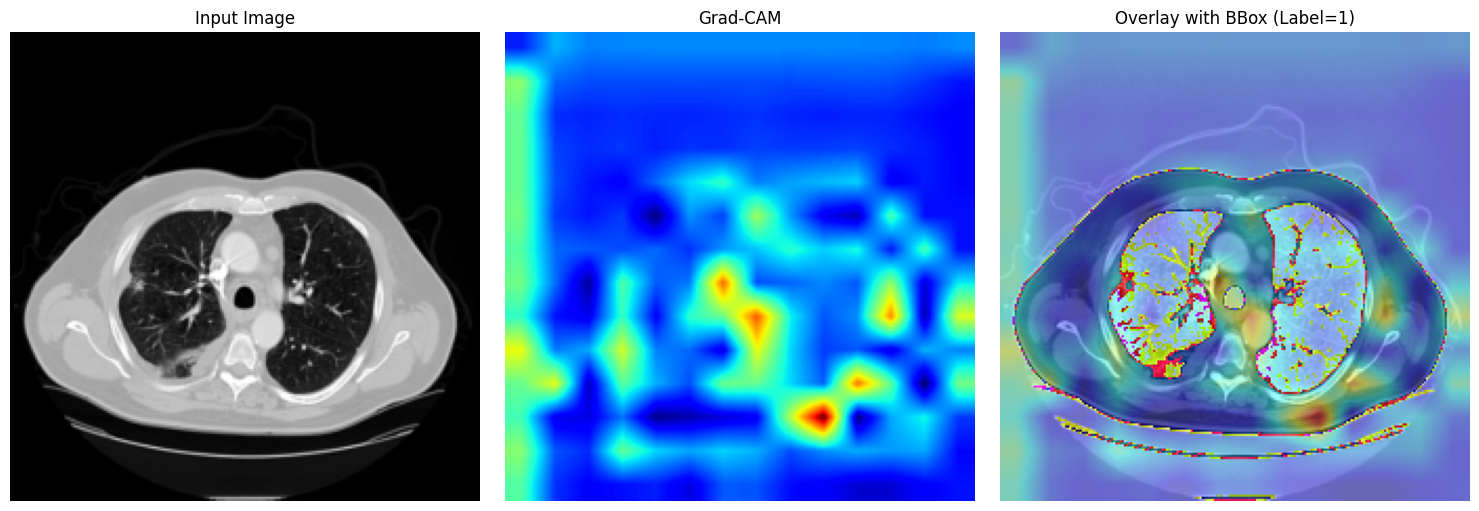

In [12]:
# ✅ Grad-CAM + Bounding Box Overlay (최종 통합 코드)

import os, re, numpy as np, torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F
import pandas as pd
import cv2
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn

# -------------------- 설정 --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
save_path = "/home/iujeong/lung_cancer/pth/aug_resnet_cbam_3.pth"
image_size = (224, 224)

# -------------------- Transform --------------------
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# -------------------- 라벨 추출 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except: return None

# -------------------- Bounding Box 로드 --------------------
def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']
        slice_str = row['slice']
        slice_idx = int(re.findall(r'\d+', str(slice_str))[0])
        fname = f"{pid}_slice{slice_idx:03d}.npy"
        bbox = eval(row['bb'])
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

bbox_dict = load_bbox_dict(bbox_csv_path)

# -------------------- Dataset --------------------
class CTDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        file_path = self.paths[idx]
        label = self.labels[idx]

        img = np.load(file_path).astype(np.float32)
        img = np.clip(img, -1000, 400)
        img = (img + 1000) / 1400.
        img = np.expand_dims(img, axis=-1)
        img_tensor = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        fname = os.path.basename(file_path)
        return img_tensor, torch.tensor(label).long(), fname, file_path

    def __len__(self): return len(self.paths)

# -------------------- CBAM --------------------
class ChannelAttention(nn.Module):
    def __init__(self, planes, ratio=16):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(planes, planes // ratio, 1, bias=False), nn.ReLU(),
            nn.Conv2d(planes // ratio, planes, 1, bias=False))
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.max = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.shared(self.avg(x)) + self.shared(self.max(x)))

class SpatialAttention(nn.Module):
    def __init__(self, k=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=k // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        _max = torch.max(x, dim=1, keepdim=True)[0]
        return self.sigmoid(self.conv(torch.cat([avg, _max], dim=1)))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()
        self.last_attention = None

    def forward(self, x):
        x = self.ca(x) * x
        self.last_attention = self.sa(x)
        return self.last_attention * x

class BasicBlockCBAM(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None, use_cbam=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.cbam = CBAM(out_planes) if use_cbam else None
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.cbam: out = self.cbam(out)
        if self.downsample: identity = self.downsample(x)
        return self.relu(out + identity)

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2, use_cbam=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1, use_cbam=True):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes))
        layers = [BasicBlockCBAM(self.in_planes, planes, stride, downsample, use_cbam)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlockCBAM(self.in_planes, planes, use_cbam=use_cbam))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))


# 🔍 Grad-CAM
def generate_gradcam(model, image, target_layer, class_idx=None):
    activations, gradients = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)
    if image.ndim == 3: image = image.unsqueeze(0)
    model.zero_grad()
    output = model(image.to(device))
    if class_idx is None: class_idx = output.argmax().item()
    output[0, class_idx].backward()
    act = activations[0].detach(); grad = gradients[0].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    hook_fwd.remove(); hook_bwd.remove()
    return cam.cpu().numpy()

# 📦 Load 모델 & 데이터
all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)
_, temp_files, _, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
_, test_files, _, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)
test_loader = DataLoader(CTDataset(test_files, test_labels, transform=val_transform), batch_size=1)
model = ResNet18_CBAM().to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 🎯 추론 및 시각화
img_tensor, label, fname, file_path = next(iter(test_loader))
if isinstance(file_path, tuple):
    file_path = file_path[0]
if isinstance(fname, tuple):
    fname = fname[0]
cam = generate_gradcam(model, img_tensor, model.layer3[1], class_idx=label.item())
img_np = img_tensor.squeeze().cpu().numpy()
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = (heatmap * 0.4 + np.stack([img_np]*3, axis=-1) * 255 * 0.6).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_np, cmap='gray'); axes[0].axis('off'); axes[0].set_title("Input Image")
axes[1].imshow(cam, cmap='jet'); axes[1].axis('off'); axes[1].set_title("Grad-CAM")
axes[2].imshow(overlay); axes[2].axis('off'); axes[2].set_title(f"Overlay with BBox (Label={label.item()})")

orig_h, orig_w = np.load(file_path).shape
for x1, y1, x2, y2 in bbox_dict.get(fname, []):
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
    axes[2].add_patch(rect)

plt.tight_layout(); plt.show()


In [13]:
import os
from tqdm import tqdm

output_dir = "./gradcam_results"
os.makedirs(output_dir, exist_ok=True)

# 몇 장 저장할지 설정
num_samples = 20

# 모델 불러오기 (이미 불러온 경우 생략 가능)
model = ResNet18_CBAM().to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# Grad-CAM 생성 함수는 기존과 동일
def generate_gradcam(model, image, target_layer, class_idx=None):
    activations, gradients = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)

    if image.ndim == 3:
        image = image.unsqueeze(0)

    model.zero_grad()
    output = model(image.to(device))
    if class_idx is None:
        class_idx = output.argmax().item()
    output[0, class_idx].backward()

    act = activations[0].detach()
    grad = gradients[0].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    hook_fwd.remove(); hook_bwd.remove()
    return cam.cpu().numpy()

# 시각화 함수 (저장까지)
def save_gradcam_overlay(img_tensor, label, fname, file_path, cam, idx):
    img_np = img_tensor.squeeze().cpu().numpy()
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (heatmap * 0.4 + np.stack([img_np]*3, axis=-1) * 255 * 0.6).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_np, cmap='gray'); axes[0].axis('off'); axes[0].set_title("Input Image")
    axes[1].imshow(cam, cmap='jet'); axes[1].axis('off'); axes[1].set_title("Grad-CAM")
    axes[2].imshow(overlay); axes[2].axis('off'); axes[2].set_title(f"Overlay with BBox (Label={label.item()})")

    # BBox 그리기
    orig_h, orig_w = np.load(file_path).shape
    for x1, y1, x2, y2 in bbox_dict.get(fname, []):
        x1 = int(x1 * image_size[1] / orig_w)
        x2 = int(x2 * image_size[1] / orig_w)
        y1 = int(y1 * image_size[0] / orig_h)
        y2 = int(y2 * image_size[0] / orig_h)
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
        axes[2].add_patch(rect)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/sample_{idx:03d}_{fname.replace('.npy', '')}.png")
    plt.close()

# -------------------- 실행 --------------------
for idx, (img_tensor, label, fname, file_path) in tqdm(enumerate(test_loader), total=num_samples):
    if idx >= num_samples: break
    img_tensor = img_tensor.squeeze(0)  # [1, C, H, W] → [C, H, W]
    cam = generate_gradcam(model, img_tensor, model.layer3[1], class_idx=label.item())
    save_gradcam_overlay(img_tensor, label, fname[0] if isinstance(fname, tuple) else fname, file_path[0] if isinstance(file_path, tuple) else file_path, cam, idx)

100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


In [8]:
print(fname)

('slice_078_5.npy',)


In [6]:
from glob import glob
import numpy as np
import os

slice_root = "/data1/lidc-idri/slices"  # 경로 수정 필요시 해줘
paths = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))

shapes = []
for p in paths:
    try:
        img = np.load(p)
        shapes.append(img.shape)
    except:
        print(f"❌ 오류 파일: {p}")

# 높이와 너비 분리
heights = [s[0] for s in shapes]
widths = [s[1] for s in shapes]

print(f"총 이미지 수: {len(shapes)}")
print(f"🧠 Height - min: {min(heights)}, max: {max(heights)}")
print(f"🫁 Width  - min: {min(widths)},  max: {max(widths)}")

총 이미지 수: 7849
🧠 Height - min: 236, max: 500
🫁 Width  - min: 236,  max: 500


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


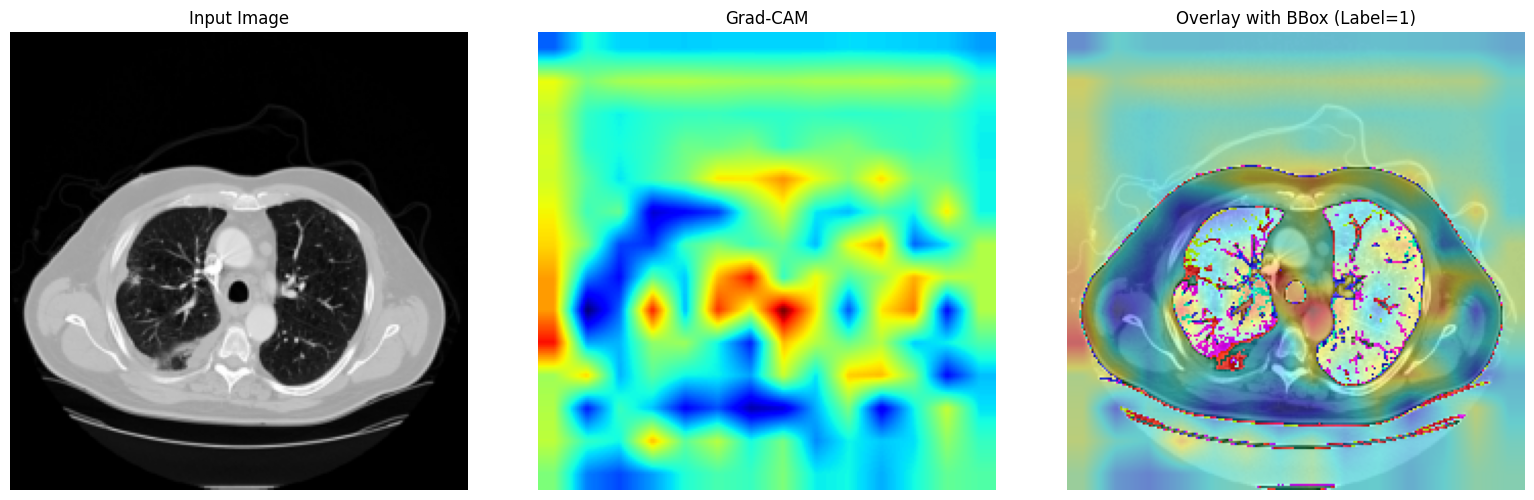

In [19]:
# Grad-CAM

import os, re, numpy as np, torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as transforms
import matplotlib.patches as patches

# -------------------- 설정 --------------------
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
save_path = "/home/iujeong/lung_cancer/pth/aug_resnet_cbam_3.pth"
image_size = (224, 224)
batch_size = 16

# -------------------- Transform --------------------
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# -------------------- 라벨 추출 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except: return None

# -------------------- Bounding Box 로드 --------------------
def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']
        slice_str = row['slice']
        slice_idx = int(re.findall(r'\d+', str(slice_str))[0])
        fname = f"{pid}_slice{slice_idx:03d}.npy"
        bbox = eval(row['bb'])
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

bbox_dict = load_bbox_dict(bbox_csv_path)

# -------------------- Dataset --------------------
class CTDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        file_path = self.paths[idx]
        label = self.labels[idx]
        fname = os.path.basename(file_path)

        img = np.load(file_path).astype(np.float32)
        img = np.clip(img, -1000, 400)
        img = (img + 1000) / 1400.
        img = np.expand_dims(img, axis=-1)

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)

        if fname in bbox_dict:
            mask = np.zeros(image_size, dtype=np.float32)
            for x_min, y_min, x_max, y_max in bbox_dict[fname]:
                mask[y_min:y_max, x_min:x_max] = 1.0
            mask = torch.tensor(mask).unsqueeze(0)
        else:
            mask = torch.zeros((1, *image_size), dtype=torch.float32)

        return img, torch.tensor(label).long(), mask.squeeze(0)

    def __len__(self): return len(self.paths)

# -------------------- DataLoader --------------------
all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)
_, temp_files, _, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
_, test_files, _, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

test_loader = DataLoader(CTDataset(test_files, test_labels, transform=val_transform), batch_size=1, shuffle=False)

# -------------------- 모델 정의 (ResNet18_CBAM) --------------------
# ❗❗ 여기에 ResNet18_CBAM 클래스를 정의해주어야 함

# -------------------- Grad-CAM --------------------
target_layer = model.layer3[1]
gradients = None
activations = None

def forward_hook(module, input, output):
    global activations
    activations = output.detach()

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

def generate_gradcam(model, img_tensor, class_idx=None):
    global activations, gradients
    img_tensor = img_tensor.unsqueeze(0).to(device)
    model.zero_grad()
    output = model(img_tensor)
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    score = output[0, class_idx]
    score.backward()

    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=image_size, mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    return cam

def show_gradcam_with_bbox(image_tensor, cam, fname, label, bbox_dict):
    img_np = image_tensor.cpu().squeeze().numpy()
    cam_np = cam.squeeze()
    cam_normalized = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_normalized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (heatmap * 0.4 + np.stack([img_np]*3, axis=2) * 255 * 0.6).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    axes[0].imshow(img_np, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(cam_np, cmap='jet')
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title(f"Overlay with BBox (Label={label})")
    axes[2].axis('off')

    if fname in bbox_dict:
        for bbox in bbox_dict[fname]:
            x1, y1, x2, y2 = bbox
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            axes[2].add_patch(rect)

    plt.tight_layout()
    plt.show()

# -------------------- 실행 --------------------
img_tensor, label, mask = test_loader.dataset[0]
fname = os.path.basename(test_loader.dataset.paths[0])
cam = generate_gradcam(model, img_tensor, class_idx=label.item())
show_gradcam_with_bbox(img_tensor, cam, fname, label.item(), bbox_dict)


In [ ]:
# 데이터 증강
# Resize / Rotation / RandomErasing

import os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from glob import glob
from tqdm import tqdm
import cv2

import torchvision.transforms as transforms
from PIL import Image

# 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# 하이퍼파라미터 설정
slice_root = "/data1/lidc-idri/slices"
batch_size = 16
num_epochs = 100
learning_rate = 1e-4


# --- Transform 정의 ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # 먼저 Tensor로 변환
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0)  # 마지막에 적용
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])



# -------------------- 데이터 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except: return None

class CTDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        img = np.load(self.paths[idx])
        img = np.clip(img, -1000, 400)
        img = (img + 1000) / 1400.  # 정규화 (0~1)
        img = np.expand_dims(img, axis=-1)  # (H, W, 1)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)  # [C, H, W]
        return img, torch.tensor(self.labels[idx]).long()

    def __len__(self): return len(self.paths)


# -------------------- CBAM & BAM --------------------
class ChannelAttention(nn.Module):
    def __init__(self, planes, ratio=16):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(planes, planes // ratio, 1, bias=False), nn.ReLU(),
            nn.Conv2d(planes // ratio, planes, 1, bias=False))
        self.avg, self.max, self.sigmoid = nn.AdaptiveAvgPool2d(1), nn.AdaptiveMaxPool2d(1), nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.shared(self.avg(x)) + self.shared(self.max(x)))

class SpatialAttention(nn.Module):
    def __init__(self, k=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=k // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg, _max = torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]
        return self.sigmoid(self.conv(torch.cat([avg, _max], dim=1)))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x) * x) * x
    



# -------------------- ResNet + CBAM --------------------
class BasicBlockCBAM(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None, use_cbam=True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.cbam = CBAM(out_planes) if use_cbam else None
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.cbam: out = self.cbam(out)
        if self.downsample: residual = self.downsample(x)
        return self.relu(out + residual)

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(64, 2)                 # CBAM 적용
        self.layer2 = self._make_layer(128, 2, stride=2)       # CBAM 적용
        self.layer3 = self._make_layer(256, 2, stride=2)       # CBAM 적용
        self.layer4 = self._make_layer(512, 2, stride=2, use_cbam=False)  # CBAM 미적용

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1, use_cbam=True):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = [BasicBlockCBAM(self.in_planes, planes, stride, downsample, use_cbam=use_cbam)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlockCBAM(self.in_planes, planes, use_cbam=use_cbam))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))
    



# -------------------- 학습 & 평가 --------------------
def run():
    all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
    file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
    file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
    files, labels = zip(*file_label_pairs)
    train_files, temp_files, train_labels, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
    val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

    train_loader = DataLoader(CTDataset(train_files, train_labels, transform=train_transform), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(CTDataset(val_files, val_labels, transform=val_transform), batch_size=batch_size)
    test_loader = DataLoader(CTDataset(test_files, test_labels, transform=val_transform), batch_size=batch_size)

    model = ResNet18_CBAM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_acc = 0.0
    save_path = os.path.join(os.path.dirname(os.getcwd()), "pth", "aug_resnet_cbam_1.pth")

    for epoch in range(num_epochs):
        model.train(); epoch_loss = 0; correct = total = 0
        for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            epoch_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"Train Acc: {(correct/total)*100:.4f}, Loss: {epoch_loss/len(train_loader):.4f}")

        # Validation
        model.eval(); correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print("✅ Saved best model!")

    # --- 테스트 ---
    print("\n📊 Test Evaluation:")
    model.load_state_dict(torch.load(save_path)); model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)
            y_probs.extend(probs.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    print(f"✅ Test Accuracy: {(np.array(y_pred) == np.array(y_true)).mean() * 100:.2f}%")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"AUC: {roc_auc_score(y_true, y_probs):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    run()

In [ ]:
# 데이터 증강
# Rotation /  / 

import os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from glob import glob
from tqdm import tqdm
import cv2

import torchvision.transforms as transforms
from PIL import Image

# 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# 하이퍼파라미터 설정
slice_root = "/data1/lidc-idri/slices"
batch_size = 16
num_epochs = 100
learning_rate = 1e-4


# --- Transform 정의 ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.CenterCrop(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.CenterCrop(180),
    transforms.ToTensor()
])



# -------------------- 데이터 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except: return None

class CTDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        img = np.load(self.paths[idx])
        img = np.clip(img, -1000, 400)
        img = (img + 1000) / 1400.  # 정규화 (0~1)
        img = np.expand_dims(img, axis=-1)  # (H, W, 1)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)  # [C, H, W]
        return img, torch.tensor(self.labels[idx]).long()

    def __len__(self): return len(self.paths)


# -------------------- CBAM & BAM --------------------
class ChannelAttention(nn.Module):
    def __init__(self, planes, ratio=16):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(planes, planes // ratio, 1, bias=False), nn.ReLU(),
            nn.Conv2d(planes // ratio, planes, 1, bias=False))
        self.avg, self.max, self.sigmoid = nn.AdaptiveAvgPool2d(1), nn.AdaptiveMaxPool2d(1), nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.shared(self.avg(x)) + self.shared(self.max(x)))

class SpatialAttention(nn.Module):
    def __init__(self, k=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=k // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg, _max = torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]
        return self.sigmoid(self.conv(torch.cat([avg, _max], dim=1)))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x) * x) * x
    



# -------------------- ResNet + CBAM --------------------
class BasicBlockCBAM(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None, use_cbam=True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.cbam = CBAM(out_planes) if use_cbam else None
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.cbam: out = self.cbam(out)
        if self.downsample: residual = self.downsample(x)
        return self.relu(out + residual)

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(64, 2)                 # CBAM 적용
        self.layer2 = self._make_layer(128, 2, stride=2)       # CBAM 적용
        self.layer3 = self._make_layer(256, 2, stride=2)       # CBAM 적용
        self.layer4 = self._make_layer(512, 2, stride=2, use_cbam=False)  # CBAM 미적용

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1, use_cbam=True):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = [BasicBlockCBAM(self.in_planes, planes, stride, downsample, use_cbam=use_cbam)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlockCBAM(self.in_planes, planes, use_cbam=use_cbam))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))
    



# -------------------- 학습 & 평가 --------------------
def run():
    all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
    file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
    file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
    files, labels = zip(*file_label_pairs)
    train_files, temp_files, train_labels, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
    val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

    train_loader = DataLoader(CTDataset(train_files, train_labels, transform=train_transform), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(CTDataset(val_files, val_labels, transform=val_transform), batch_size=batch_size)
    test_loader = DataLoader(CTDataset(test_files, test_labels, transform=val_transform), batch_size=batch_size)

    model = ResNet18_CBAM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    save_path = os.path.join(os.path.dirname(os.getcwd()), "pth", "aug_resnet_cbam.pth")
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train(); epoch_loss = 0; correct = total = 0
        for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            epoch_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"Train Acc: {(correct/total)*100:.4f}, Loss: {epoch_loss/len(train_loader):.4f}")

        # Validation
        model.eval(); correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print("✅ Saved best model!")

    # --- 테스트 ---
    print("\n📊 Test Evaluation:")
    model.load_state_dict(torch.load(save_path)); model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)
            y_probs.extend(probs.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    print(f"✅ Test Accuracy: {(np.array(y_pred) == np.array(y_true)).mean() * 100:.2f}%")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"AUC: {roc_auc_score(y_true, y_probs):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    run()

cuda:1


[Epoch 1]: 100%|██████████| 234/234 [00:07<00:00, 29.44it/s]


Train Acc: 64.3355, Loss: 0.6515
Val Acc: 0.6850
✅ Saved best model!


[Epoch 2]: 100%|██████████| 234/234 [00:07<00:00, 29.46it/s]


Train Acc: 65.3269, Loss: 0.6360
Val Acc: 0.6600


[Epoch 3]: 100%|██████████| 234/234 [00:07<00:00, 30.06it/s]


Train Acc: 66.3451, Loss: 0.6260
Val Acc: 0.6950
✅ Saved best model!


[Epoch 4]: 100%|██████████| 234/234 [00:07<00:00, 29.86it/s]


Train Acc: 67.0150, Loss: 0.6177
Val Acc: 0.6837


[Epoch 5]: 100%|██████████| 234/234 [00:07<00:00, 30.10it/s]


Train Acc: 66.9882, Loss: 0.6141
Val Acc: 0.6875


[Epoch 6]: 100%|██████████| 234/234 [00:07<00:00, 30.77it/s]


Train Acc: 68.0868, Loss: 0.6033
Val Acc: 0.6875


[Epoch 7]: 100%|██████████| 234/234 [00:07<00:00, 30.86it/s]


Train Acc: 68.2208, Loss: 0.6056
Val Acc: 0.6950


[Epoch 8]: 100%|██████████| 234/234 [00:07<00:00, 30.09it/s]


Train Acc: 68.8371, Loss: 0.6010
Val Acc: 0.6725


[Epoch 9]: 100%|██████████| 234/234 [00:07<00:00, 30.73it/s]


Train Acc: 68.7835, Loss: 0.5947
Val Acc: 0.6925


[Epoch 10]: 100%|██████████| 234/234 [00:07<00:00, 29.88it/s]


Train Acc: 68.7835, Loss: 0.5960
Val Acc: 0.7125
✅ Saved best model!


[Epoch 11]: 100%|██████████| 234/234 [00:07<00:00, 30.25it/s]


Train Acc: 70.1233, Loss: 0.5819
Val Acc: 0.6937


[Epoch 12]: 100%|██████████| 234/234 [00:07<00:00, 30.11it/s]


Train Acc: 69.9893, Loss: 0.5815
Val Acc: 0.6613


[Epoch 13]: 100%|██████████| 234/234 [00:07<00:00, 30.90it/s]


Train Acc: 69.1050, Loss: 0.5780
Val Acc: 0.7087


[Epoch 14]: 100%|██████████| 234/234 [00:07<00:00, 30.12it/s]


Train Acc: 70.4448, Loss: 0.5701
Val Acc: 0.6887


[Epoch 15]: 100%|██████████| 234/234 [00:07<00:00, 30.21it/s]


Train Acc: 70.1501, Loss: 0.5678
Val Acc: 0.6713


[Epoch 16]: 100%|██████████| 234/234 [00:07<00:00, 31.01it/s]


Train Acc: 71.7310, Loss: 0.5550
Val Acc: 0.7000


[Epoch 17]: 100%|██████████| 234/234 [00:07<00:00, 30.13it/s]


Train Acc: 71.2487, Loss: 0.5588
Val Acc: 0.7013


[Epoch 18]: 100%|██████████| 234/234 [00:07<00:00, 30.90it/s]


Train Acc: 72.0793, Loss: 0.5493
Val Acc: 0.6937


[Epoch 19]: 100%|██████████| 234/234 [00:07<00:00, 30.58it/s]


Train Acc: 72.6420, Loss: 0.5416
Val Acc: 0.7200
✅ Saved best model!


[Epoch 20]: 100%|██████████| 234/234 [00:07<00:00, 30.11it/s]


Train Acc: 73.0439, Loss: 0.5299
Val Acc: 0.7288
✅ Saved best model!


[Epoch 21]: 100%|██████████| 234/234 [00:07<00:00, 30.50it/s]


Train Acc: 73.5798, Loss: 0.5302
Val Acc: 0.7087


[Epoch 22]: 100%|██████████| 234/234 [00:07<00:00, 29.37it/s]


Train Acc: 74.4641, Loss: 0.5113
Val Acc: 0.6825


[Epoch 23]: 100%|██████████| 234/234 [00:07<00:00, 30.33it/s]


Train Acc: 75.1876, Loss: 0.5034
Val Acc: 0.6687


[Epoch 24]: 100%|██████████| 234/234 [00:07<00:00, 29.63it/s]


Train Acc: 75.3215, Loss: 0.5012
Val Acc: 0.7362
✅ Saved best model!


[Epoch 25]: 100%|██████████| 234/234 [00:08<00:00, 28.68it/s]


Train Acc: 75.8574, Loss: 0.4912
Val Acc: 0.7338


[Epoch 26]: 100%|██████████| 234/234 [00:07<00:00, 29.75it/s]


Train Acc: 76.5541, Loss: 0.4867
Val Acc: 0.7075


[Epoch 27]: 100%|██████████| 234/234 [00:07<00:00, 30.17it/s]


Train Acc: 77.1168, Loss: 0.4707
Val Acc: 0.7275


[Epoch 28]: 100%|██████████| 234/234 [00:07<00:00, 30.08it/s]


Train Acc: 78.0279, Loss: 0.4594
Val Acc: 0.7350


[Epoch 29]: 100%|██████████| 234/234 [00:07<00:00, 29.72it/s]


Train Acc: 78.0815, Loss: 0.4514
Val Acc: 0.7438
✅ Saved best model!


[Epoch 30]: 100%|██████████| 234/234 [00:07<00:00, 31.10it/s]


Train Acc: 79.5284, Loss: 0.4421
Val Acc: 0.7125


[Epoch 31]: 100%|██████████| 234/234 [00:07<00:00, 30.37it/s]


Train Acc: 79.8499, Loss: 0.4266
Val Acc: 0.7425


[Epoch 32]: 100%|██████████| 234/234 [00:07<00:00, 29.88it/s]


Train Acc: 80.4930, Loss: 0.4139
Val Acc: 0.7400


[Epoch 33]: 100%|██████████| 234/234 [00:07<00:00, 29.45it/s]


Train Acc: 80.4394, Loss: 0.4139
Val Acc: 0.7438


[Epoch 34]: 100%|██████████| 234/234 [00:07<00:00, 29.77it/s]


Train Acc: 80.7878, Loss: 0.4083
Val Acc: 0.7712
✅ Saved best model!


[Epoch 35]: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train Acc: 81.8328, Loss: 0.3951
Val Acc: 0.7638


[Epoch 36]: 100%|██████████| 234/234 [00:07<00:00, 30.58it/s]


Train Acc: 82.6635, Loss: 0.3667
Val Acc: 0.7675


[Epoch 37]: 100%|██████████| 234/234 [00:07<00:00, 30.37it/s]


Train Acc: 83.6013, Loss: 0.3664
Val Acc: 0.7762
✅ Saved best model!


[Epoch 38]: 100%|██████████| 234/234 [00:07<00:00, 30.31it/s]


Train Acc: 83.8156, Loss: 0.3636
Val Acc: 0.7775
✅ Saved best model!


[Epoch 39]: 100%|██████████| 234/234 [00:07<00:00, 30.79it/s]


Train Acc: 84.2444, Loss: 0.3504
Val Acc: 0.7788
✅ Saved best model!


[Epoch 40]: 100%|██████████| 234/234 [00:08<00:00, 28.33it/s]


Train Acc: 84.3516, Loss: 0.3465
Val Acc: 0.7625


[Epoch 41]: 100%|██████████| 234/234 [00:07<00:00, 30.87it/s]


Train Acc: 84.6463, Loss: 0.3295
Val Acc: 0.7913
✅ Saved best model!


[Epoch 42]: 100%|██████████| 234/234 [00:07<00:00, 30.43it/s]


Train Acc: 84.8339, Loss: 0.3438
Val Acc: 0.7800


[Epoch 43]: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train Acc: 87.2990, Loss: 0.3123
Val Acc: 0.7500


[Epoch 44]: 100%|██████████| 234/234 [00:07<00:00, 30.09it/s]


Train Acc: 85.6645, Loss: 0.3160
Val Acc: 0.7638


[Epoch 45]: 100%|██████████| 234/234 [00:07<00:00, 29.89it/s]


Train Acc: 86.5220, Loss: 0.3186
Val Acc: 0.8000
✅ Saved best model!


[Epoch 46]: 100%|██████████| 234/234 [00:07<00:00, 29.76it/s]


Train Acc: 87.1651, Loss: 0.2960
Val Acc: 0.7913


[Epoch 47]: 100%|██████████| 234/234 [00:07<00:00, 31.01it/s]


Train Acc: 86.6292, Loss: 0.3124
Val Acc: 0.7725


[Epoch 48]: 100%|██████████| 234/234 [00:07<00:00, 29.94it/s]


Train Acc: 86.9239, Loss: 0.2898
Val Acc: 0.7775


[Epoch 49]: 100%|██████████| 234/234 [00:07<00:00, 30.18it/s]


Train Acc: 87.2186, Loss: 0.2827
Val Acc: 0.7900


[Epoch 50]: 100%|██████████| 234/234 [00:07<00:00, 30.13it/s]


Train Acc: 88.6656, Loss: 0.2681
Val Acc: 0.8000


[Epoch 51]: 100%|██████████| 234/234 [00:10<00:00, 22.34it/s]


Train Acc: 88.3976, Loss: 0.2757
Val Acc: 0.7987


[Epoch 52]: 100%|██████████| 234/234 [00:14<00:00, 16.49it/s]


Train Acc: 88.5048, Loss: 0.2681
Val Acc: 0.7937


[Epoch 53]: 100%|██████████| 234/234 [00:14<00:00, 16.05it/s]


Train Acc: 88.4512, Loss: 0.2622
Val Acc: 0.8150
✅ Saved best model!


[Epoch 54]: 100%|██████████| 234/234 [00:14<00:00, 16.10it/s]


Train Acc: 88.1833, Loss: 0.2727
Val Acc: 0.8087


[Epoch 55]: 100%|██████████| 234/234 [00:15<00:00, 15.11it/s]


Train Acc: 88.9603, Loss: 0.2631
Val Acc: 0.7913


[Epoch 56]: 100%|██████████| 234/234 [00:13<00:00, 17.35it/s]


Train Acc: 89.7910, Loss: 0.2450
Val Acc: 0.7837


[Epoch 57]: 100%|██████████| 234/234 [00:14<00:00, 15.69it/s]


Train Acc: 89.8982, Loss: 0.2422
Val Acc: 0.8287
✅ Saved best model!


[Epoch 58]: 100%|██████████| 234/234 [00:13<00:00, 17.08it/s]


Train Acc: 89.4427, Loss: 0.2428
Val Acc: 0.7913


[Epoch 59]: 100%|██████████| 234/234 [00:13<00:00, 17.46it/s]


Train Acc: 89.6838, Loss: 0.2431
Val Acc: 0.8113


[Epoch 60]: 100%|██████████| 234/234 [00:15<00:00, 15.45it/s]


Train Acc: 90.7288, Loss: 0.2301
Val Acc: 0.8075


[Epoch 61]: 100%|██████████| 234/234 [00:13<00:00, 16.79it/s]


Train Acc: 90.9968, Loss: 0.2230
Val Acc: 0.8163


[Epoch 62]: 100%|██████████| 234/234 [00:14<00:00, 16.00it/s]


Train Acc: 90.8360, Loss: 0.2157
Val Acc: 0.7863


[Epoch 63]: 100%|██████████| 234/234 [00:15<00:00, 15.50it/s]


Train Acc: 90.4341, Loss: 0.2320
Val Acc: 0.7800


[Epoch 64]: 100%|██████████| 234/234 [00:15<00:00, 15.41it/s]


Train Acc: 91.8006, Loss: 0.2027
Val Acc: 0.7950


[Epoch 65]: 100%|██████████| 234/234 [00:13<00:00, 17.19it/s]


Train Acc: 90.9164, Loss: 0.2114
Val Acc: 0.7538


[Epoch 66]: 100%|██████████| 234/234 [00:14<00:00, 16.27it/s]


Train Acc: 92.1222, Loss: 0.1994
Val Acc: 0.8287


[Epoch 67]: 100%|██████████| 234/234 [00:13<00:00, 17.36it/s]


Train Acc: 91.2379, Loss: 0.2180
Val Acc: 0.8300
✅ Saved best model!


[Epoch 68]: 100%|██████████| 234/234 [00:14<00:00, 16.22it/s]


Train Acc: 91.0772, Loss: 0.2153
Val Acc: 0.8225


[Epoch 69]: 100%|██████████| 234/234 [00:14<00:00, 15.62it/s]


Train Acc: 91.3719, Loss: 0.2073
Val Acc: 0.8263


[Epoch 70]: 100%|██████████| 234/234 [00:14<00:00, 15.86it/s]


Train Acc: 92.6045, Loss: 0.1860
Val Acc: 0.8075


[Epoch 71]: 100%|██████████| 234/234 [00:16<00:00, 14.42it/s]


Train Acc: 91.6399, Loss: 0.2035
Val Acc: 0.8263


[Epoch 72]: 100%|██████████| 234/234 [00:14<00:00, 16.45it/s]


Train Acc: 92.6313, Loss: 0.1868
Val Acc: 0.8000


[Epoch 73]: 100%|██████████| 234/234 [00:14<00:00, 16.13it/s]


Train Acc: 91.7203, Loss: 0.1905
Val Acc: 0.8163


[Epoch 74]: 100%|██████████| 234/234 [00:14<00:00, 16.71it/s]


Train Acc: 92.9796, Loss: 0.1779
Val Acc: 0.8325
✅ Saved best model!


[Epoch 75]: 100%|██████████| 234/234 [00:16<00:00, 14.38it/s]


Train Acc: 92.8992, Loss: 0.1762
Val Acc: 0.8000


[Epoch 76]: 100%|██████████| 234/234 [00:14<00:00, 16.25it/s]


Train Acc: 92.4169, Loss: 0.1885
Val Acc: 0.8413
✅ Saved best model!


[Epoch 77]: 100%|██████████| 234/234 [00:15<00:00, 15.26it/s]


Train Acc: 92.5241, Loss: 0.1773
Val Acc: 0.8037


[Epoch 78]: 100%|██████████| 234/234 [00:15<00:00, 15.32it/s]


Train Acc: 92.5777, Loss: 0.1860
Val Acc: 0.8337


[Epoch 79]: 100%|██████████| 234/234 [00:14<00:00, 16.59it/s]


Train Acc: 93.1136, Loss: 0.1744
Val Acc: 0.8350


[Epoch 80]: 100%|██████████| 234/234 [00:14<00:00, 16.21it/s]


Train Acc: 94.2658, Loss: 0.1524
Val Acc: 0.8488
✅ Saved best model!


[Epoch 81]: 100%|██████████| 234/234 [00:14<00:00, 15.65it/s]


Train Acc: 93.1672, Loss: 0.1778
Val Acc: 0.8163


[Epoch 82]: 100%|██████████| 234/234 [00:14<00:00, 16.68it/s]


Train Acc: 93.2208, Loss: 0.1738
Val Acc: 0.8512
✅ Saved best model!


[Epoch 83]: 100%|██████████| 234/234 [00:15<00:00, 15.39it/s]


Train Acc: 92.9796, Loss: 0.1664
Val Acc: 0.8100


[Epoch 84]: 100%|██████████| 234/234 [00:14<00:00, 15.73it/s]


Train Acc: 93.7567, Loss: 0.1615
Val Acc: 0.8363


[Epoch 85]: 100%|██████████| 234/234 [00:14<00:00, 16.09it/s]


Train Acc: 94.5338, Loss: 0.1488
Val Acc: 0.8363


[Epoch 86]: 100%|██████████| 234/234 [00:14<00:00, 16.04it/s]


Train Acc: 93.7031, Loss: 0.1598
Val Acc: 0.8337


[Epoch 87]: 100%|██████████| 234/234 [00:14<00:00, 16.69it/s]


Train Acc: 94.0782, Loss: 0.1522
Val Acc: 0.8450


[Epoch 88]: 100%|██████████| 234/234 [00:14<00:00, 16.42it/s]


Train Acc: 94.0782, Loss: 0.1565
Val Acc: 0.8538
✅ Saved best model!


[Epoch 89]: 100%|██████████| 234/234 [00:14<00:00, 15.94it/s]


Train Acc: 94.0514, Loss: 0.1500
Val Acc: 0.8562
✅ Saved best model!


[Epoch 90]: 100%|██████████| 234/234 [00:15<00:00, 15.47it/s]


Train Acc: 94.5874, Loss: 0.1393
Val Acc: 0.8313


[Epoch 91]: 100%|██████████| 234/234 [00:13<00:00, 16.96it/s]


Train Acc: 94.2658, Loss: 0.1498
Val Acc: 0.8550


[Epoch 92]: 100%|██████████| 234/234 [00:14<00:00, 16.14it/s]


Train Acc: 93.9175, Loss: 0.1525
Val Acc: 0.8375


[Epoch 93]: 100%|██████████| 234/234 [00:14<00:00, 16.27it/s]


Train Acc: 94.4534, Loss: 0.1351
Val Acc: 0.8500


[Epoch 94]: 100%|██████████| 234/234 [00:13<00:00, 17.82it/s]


Train Acc: 94.6677, Loss: 0.1415
Val Acc: 0.8013


[Epoch 95]: 100%|██████████| 234/234 [00:13<00:00, 17.95it/s]


Train Acc: 94.8553, Loss: 0.1333
Val Acc: 0.8150


[Epoch 96]: 100%|██████████| 234/234 [00:14<00:00, 16.32it/s]


Train Acc: 95.5520, Loss: 0.1257
Val Acc: 0.8475


[Epoch 97]: 100%|██████████| 234/234 [00:13<00:00, 17.91it/s]


Train Acc: 94.1050, Loss: 0.1508
Val Acc: 0.8500


[Epoch 98]: 100%|██████████| 234/234 [00:14<00:00, 16.21it/s]


Train Acc: 94.5338, Loss: 0.1359
Val Acc: 0.8462


[Epoch 99]: 100%|██████████| 234/234 [00:13<00:00, 17.22it/s]


Train Acc: 95.6056, Loss: 0.1114
Val Acc: 0.8063


[Epoch 100]: 100%|██████████| 234/234 [00:14<00:00, 16.51it/s]


Train Acc: 94.9893, Loss: 0.1308
Val Acc: 0.8525

📊 Test Evaluation:
✅ Test Accuracy: 85.50%
              precision    recall  f1-score   support

           0     0.7955    0.7782    0.7868       275
           1     0.8851    0.8952    0.8902       525

    accuracy                         0.8550       800
   macro avg     0.8403    0.8367    0.8385       800
weighted avg     0.8543    0.8550    0.8546       800

AUC: 0.9080
Confusion Matrix:
[[214  61]
 [ 55 470]]


In [ ]:
# 데이터 증강
# Rotation / CenterCrop / GaussianBlur

import os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from glob import glob
from tqdm import tqdm
import cv2

import torchvision.transforms as transforms
from PIL import Image

# 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# 하이퍼파라미터 설정
slice_root = "/data1/lidc-idri/slices"
batch_size = 16
num_epochs = 100
learning_rate = 1e-4


# --- Transform 정의 ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(180),
    transforms.ToTensor()
])



# -------------------- 데이터 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except: return None

class CTDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        img = np.load(self.paths[idx])
        img = np.clip(img, -1000, 400)
        img = (img + 1000) / 1400.  # 정규화 (0~1)
        img = np.expand_dims(img, axis=-1)  # (H, W, 1)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)  # [C, H, W]
        return img, torch.tensor(self.labels[idx]).long()

    def __len__(self): return len(self.paths)


# -------------------- CBAM & BAM --------------------
class ChannelAttention(nn.Module):
    def __init__(self, planes, ratio=16):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(planes, planes // ratio, 1, bias=False), nn.ReLU(),
            nn.Conv2d(planes // ratio, planes, 1, bias=False))
        self.avg, self.max, self.sigmoid = nn.AdaptiveAvgPool2d(1), nn.AdaptiveMaxPool2d(1), nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.shared(self.avg(x)) + self.shared(self.max(x)))

class SpatialAttention(nn.Module):
    def __init__(self, k=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=k // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg, _max = torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]
        return self.sigmoid(self.conv(torch.cat([avg, _max], dim=1)))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x) * x) * x
    



# -------------------- ResNet + CBAM --------------------
class BasicBlockCBAM(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None, use_cbam=True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.cbam = CBAM(out_planes) if use_cbam else None
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.cbam: out = self.cbam(out)
        if self.downsample: residual = self.downsample(x)
        return self.relu(out + residual)

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(64, 2)                 # CBAM 적용
        self.layer2 = self._make_layer(128, 2, stride=2)       # CBAM 적용
        self.layer3 = self._make_layer(256, 2, stride=2)       # CBAM 적용
        self.layer4 = self._make_layer(512, 2, stride=2, use_cbam=False)  # CBAM 미적용

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1, use_cbam=True):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = [BasicBlockCBAM(self.in_planes, planes, stride, downsample, use_cbam=use_cbam)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlockCBAM(self.in_planes, planes, use_cbam=use_cbam))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))
    



# -------------------- 학습 & 평가 --------------------
def run():
    all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
    file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
    file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
    files, labels = zip(*file_label_pairs)
    train_files, temp_files, train_labels, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
    val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

    train_loader = DataLoader(CTDataset(train_files, train_labels, transform=train_transform), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(CTDataset(val_files, val_labels, transform=val_transform), batch_size=batch_size)
    test_loader = DataLoader(CTDataset(test_files, test_labels, transform=val_transform), batch_size=batch_size)

    model = ResNet18_CBAM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_acc, save_path = 0.0, "aug_resnet_cbam.pth"

    for epoch in range(num_epochs):
        model.train(); epoch_loss = 0; correct = total = 0
        for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            epoch_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"Train Acc: {(correct/total)*100:.4f}, Loss: {epoch_loss/len(train_loader):.4f}")

        # Validation
        model.eval(); correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print("✅ Saved best model!")

    # --- 테스트 ---
    print("\n📊 Test Evaluation:")
    model.load_state_dict(torch.load(save_path)); model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)
            y_probs.extend(probs.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    print(f"✅ Test Accuracy: {(np.array(y_pred) == np.array(y_true)).mean() * 100:.2f}%")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"AUC: {roc_auc_score(y_true, y_probs):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    run()

cuda:1


[Epoch 1]: 100%|██████████| 234/234 [00:06<00:00, 38.33it/s]


Train Acc: 64.1479, Loss: 0.6555
Val Acc: 0.6175
✅ Saved best model!


[Epoch 2]: 100%|██████████| 234/234 [00:06<00:00, 37.37it/s]


Train Acc: 65.8360, Loss: 0.6293
Val Acc: 0.6625
✅ Saved best model!


[Epoch 3]: 100%|██████████| 234/234 [00:06<00:00, 38.67it/s]


Train Acc: 67.0150, Loss: 0.6191
Val Acc: 0.6913
✅ Saved best model!


[Epoch 4]: 100%|██████████| 234/234 [00:06<00:00, 36.44it/s]


Train Acc: 66.6935, Loss: 0.6105
Val Acc: 0.6200


[Epoch 5]: 100%|██████████| 234/234 [00:06<00:00, 37.62it/s]


Train Acc: 68.3816, Loss: 0.5999
Val Acc: 0.6375


[Epoch 6]: 100%|██████████| 234/234 [00:06<00:00, 38.48it/s]


Train Acc: 68.6495, Loss: 0.5856
Val Acc: 0.6963
✅ Saved best model!


[Epoch 7]: 100%|██████████| 234/234 [00:06<00:00, 37.99it/s]


Train Acc: 69.3730, Loss: 0.5711
Val Acc: 0.6963


[Epoch 8]: 100%|██████████| 234/234 [00:06<00:00, 38.55it/s]


Train Acc: 71.5702, Loss: 0.5534
Val Acc: 0.6587


[Epoch 9]: 100%|██████████| 234/234 [00:06<00:00, 37.56it/s]


Train Acc: 72.4277, Loss: 0.5356
Val Acc: 0.6963


[Epoch 10]: 100%|██████████| 234/234 [00:05<00:00, 39.22it/s]


Train Acc: 74.4373, Loss: 0.5190
Val Acc: 0.6950


[Epoch 11]: 100%|██████████| 234/234 [00:06<00:00, 38.23it/s]


Train Acc: 75.1340, Loss: 0.5080
Val Acc: 0.6038


[Epoch 12]: 100%|██████████| 234/234 [00:06<00:00, 38.55it/s]


Train Acc: 77.0632, Loss: 0.4816
Val Acc: 0.7100
✅ Saved best model!


[Epoch 13]: 100%|██████████| 234/234 [00:06<00:00, 38.90it/s]


Train Acc: 78.6174, Loss: 0.4572
Val Acc: 0.6412


[Epoch 14]: 100%|██████████| 234/234 [00:05<00:00, 39.24it/s]


Train Acc: 79.9839, Loss: 0.4414
Val Acc: 0.6787


[Epoch 15]: 100%|██████████| 234/234 [00:06<00:00, 38.66it/s]


Train Acc: 81.2969, Loss: 0.4149
Val Acc: 0.7550
✅ Saved best model!


[Epoch 16]: 100%|██████████| 234/234 [00:06<00:00, 38.75it/s]


Train Acc: 82.9314, Loss: 0.3851
Val Acc: 0.7500


[Epoch 17]: 100%|██████████| 234/234 [00:06<00:00, 37.86it/s]


Train Acc: 82.6902, Loss: 0.3918
Val Acc: 0.7125


[Epoch 18]: 100%|██████████| 234/234 [00:06<00:00, 36.68it/s]


Train Acc: 84.3783, Loss: 0.3578
Val Acc: 0.7762
✅ Saved best model!


[Epoch 19]: 100%|██████████| 234/234 [00:06<00:00, 37.15it/s]


Train Acc: 85.5573, Loss: 0.3350
Val Acc: 0.7688


[Epoch 20]: 100%|██████████| 234/234 [00:06<00:00, 37.43it/s]


Train Acc: 86.7095, Loss: 0.3159
Val Acc: 0.7600


[Epoch 21]: 100%|██████████| 234/234 [00:06<00:00, 36.35it/s]


Train Acc: 87.0847, Loss: 0.3046
Val Acc: 0.7750


[Epoch 22]: 100%|██████████| 234/234 [00:06<00:00, 38.37it/s]


Train Acc: 87.9689, Loss: 0.2845
Val Acc: 0.7700


[Epoch 23]: 100%|██████████| 234/234 [00:06<00:00, 36.61it/s]


Train Acc: 89.4159, Loss: 0.2601
Val Acc: 0.7662


[Epoch 24]: 100%|██████████| 234/234 [00:06<00:00, 38.88it/s]


Train Acc: 89.7374, Loss: 0.2654
Val Acc: 0.7700


[Epoch 25]: 100%|██████████| 234/234 [00:06<00:00, 38.83it/s]


Train Acc: 90.4073, Loss: 0.2411
Val Acc: 0.7512


[Epoch 26]: 100%|██████████| 234/234 [00:06<00:00, 38.32it/s]


Train Acc: 90.8628, Loss: 0.2316
Val Acc: 0.8137
✅ Saved best model!


[Epoch 27]: 100%|██████████| 234/234 [00:06<00:00, 35.95it/s]


Train Acc: 91.5863, Loss: 0.2189
Val Acc: 0.8137


[Epoch 28]: 100%|██████████| 234/234 [00:06<00:00, 36.95it/s]


Train Acc: 92.1222, Loss: 0.2037
Val Acc: 0.7887


[Epoch 29]: 100%|██████████| 234/234 [00:06<00:00, 37.37it/s]


Train Acc: 92.5241, Loss: 0.1942
Val Acc: 0.8163
✅ Saved best model!


[Epoch 30]: 100%|██████████| 234/234 [00:06<00:00, 38.78it/s]


Train Acc: 92.5777, Loss: 0.1989
Val Acc: 0.8250
✅ Saved best model!


[Epoch 31]: 100%|██████████| 234/234 [00:06<00:00, 36.76it/s]


Train Acc: 92.6313, Loss: 0.1886
Val Acc: 0.8125


[Epoch 32]: 100%|██████████| 234/234 [00:06<00:00, 37.26it/s]


Train Acc: 93.1672, Loss: 0.1695
Val Acc: 0.8087


[Epoch 33]: 100%|██████████| 234/234 [00:06<00:00, 37.69it/s]


Train Acc: 92.9528, Loss: 0.1733
Val Acc: 0.8187


[Epoch 34]: 100%|██████████| 234/234 [00:06<00:00, 37.72it/s]


Train Acc: 94.4266, Loss: 0.1653
Val Acc: 0.8237


[Epoch 35]: 100%|██████████| 234/234 [00:06<00:00, 36.12it/s]


Train Acc: 94.1050, Loss: 0.1542
Val Acc: 0.8275
✅ Saved best model!


[Epoch 36]: 100%|██████████| 234/234 [00:06<00:00, 38.06it/s]


Train Acc: 95.1233, Loss: 0.1337
Val Acc: 0.8225


[Epoch 37]: 100%|██████████| 234/234 [00:06<00:00, 37.06it/s]


Train Acc: 94.5874, Loss: 0.1465
Val Acc: 0.7688


[Epoch 38]: 100%|██████████| 234/234 [00:05<00:00, 39.16it/s]


Train Acc: 94.9893, Loss: 0.1346
Val Acc: 0.8187


[Epoch 39]: 100%|██████████| 234/234 [00:06<00:00, 38.27it/s]


Train Acc: 94.9089, Loss: 0.1450
Val Acc: 0.8163


[Epoch 40]: 100%|██████████| 234/234 [00:06<00:00, 38.71it/s]


Train Acc: 95.7931, Loss: 0.1142
Val Acc: 0.8287
✅ Saved best model!


[Epoch 41]: 100%|██████████| 234/234 [00:06<00:00, 38.29it/s]


Train Acc: 94.8285, Loss: 0.1366
Val Acc: 0.8425
✅ Saved best model!


[Epoch 42]: 100%|██████████| 234/234 [00:06<00:00, 38.92it/s]


Train Acc: 95.5520, Loss: 0.1143
Val Acc: 0.8125


[Epoch 43]: 100%|██████████| 234/234 [00:06<00:00, 38.74it/s]


Train Acc: 96.0343, Loss: 0.1196
Val Acc: 0.8462
✅ Saved best model!


[Epoch 44]: 100%|██████████| 234/234 [00:06<00:00, 36.26it/s]


Train Acc: 95.2840, Loss: 0.1205
Val Acc: 0.8550
✅ Saved best model!


[Epoch 45]: 100%|██████████| 234/234 [00:06<00:00, 38.43it/s]


Train Acc: 95.9003, Loss: 0.1134
Val Acc: 0.8375


[Epoch 46]: 100%|██████████| 234/234 [00:06<00:00, 38.53it/s]


Train Acc: 95.9539, Loss: 0.1126
Val Acc: 0.8425


[Epoch 47]: 100%|██████████| 234/234 [00:06<00:00, 38.70it/s]


Train Acc: 96.7042, Loss: 0.1044
Val Acc: 0.8400


[Epoch 48]: 100%|██████████| 234/234 [00:06<00:00, 37.52it/s]


Train Acc: 95.6056, Loss: 0.1217
Val Acc: 0.8400


[Epoch 49]: 100%|██████████| 234/234 [00:06<00:00, 38.60it/s]


Train Acc: 96.4362, Loss: 0.0958
Val Acc: 0.8538


[Epoch 50]: 100%|██████████| 234/234 [00:06<00:00, 38.51it/s]


Train Acc: 97.1865, Loss: 0.0839
Val Acc: 0.8275


[Epoch 51]: 100%|██████████| 234/234 [00:05<00:00, 39.02it/s]


Train Acc: 96.1683, Loss: 0.1077
Val Acc: 0.8337


[Epoch 52]: 100%|██████████| 234/234 [00:06<00:00, 38.71it/s]


Train Acc: 96.7042, Loss: 0.0888
Val Acc: 0.8337


[Epoch 53]: 100%|██████████| 234/234 [00:06<00:00, 38.62it/s]


Train Acc: 96.5970, Loss: 0.0897
Val Acc: 0.8488


[Epoch 54]: 100%|██████████| 234/234 [00:05<00:00, 39.16it/s]


Train Acc: 97.1329, Loss: 0.0862
Val Acc: 0.8213


[Epoch 55]: 100%|██████████| 234/234 [00:06<00:00, 38.41it/s]


Train Acc: 96.9185, Loss: 0.0834
Val Acc: 0.8700
✅ Saved best model!


[Epoch 56]: 100%|██████████| 234/234 [00:05<00:00, 39.06it/s]


Train Acc: 97.0793, Loss: 0.0817
Val Acc: 0.8488


[Epoch 57]: 100%|██████████| 234/234 [00:06<00:00, 38.69it/s]


Train Acc: 96.5434, Loss: 0.0964
Val Acc: 0.8612


[Epoch 58]: 100%|██████████| 234/234 [00:06<00:00, 38.25it/s]


Train Acc: 96.8382, Loss: 0.0890
Val Acc: 0.8425


[Epoch 59]: 100%|██████████| 234/234 [00:06<00:00, 38.27it/s]


Train Acc: 96.5434, Loss: 0.0858
Val Acc: 0.8375


[Epoch 60]: 100%|██████████| 234/234 [00:06<00:00, 38.69it/s]


Train Acc: 97.6152, Loss: 0.0732
Val Acc: 0.8363


[Epoch 61]: 100%|██████████| 234/234 [00:06<00:00, 38.62it/s]


Train Acc: 97.2669, Loss: 0.0792
Val Acc: 0.8525


[Epoch 62]: 100%|██████████| 234/234 [00:06<00:00, 38.89it/s]


Train Acc: 96.7042, Loss: 0.0878
Val Acc: 0.8488


[Epoch 63]: 100%|██████████| 234/234 [00:06<00:00, 38.35it/s]


Train Acc: 97.6688, Loss: 0.0737
Val Acc: 0.8525


[Epoch 64]: 100%|██████████| 234/234 [00:06<00:00, 36.89it/s]


Train Acc: 96.8382, Loss: 0.0839
Val Acc: 0.8525


[Epoch 65]: 100%|██████████| 234/234 [00:06<00:00, 37.53it/s]


Train Acc: 97.2937, Loss: 0.0784
Val Acc: 0.8575


[Epoch 66]: 100%|██████████| 234/234 [00:06<00:00, 38.00it/s]


Train Acc: 98.3119, Loss: 0.0542
Val Acc: 0.8538


[Epoch 67]: 100%|██████████| 234/234 [00:06<00:00, 38.44it/s]


Train Acc: 97.5080, Loss: 0.0710
Val Acc: 0.8562


[Epoch 68]: 100%|██████████| 234/234 [00:06<00:00, 38.70it/s]


Train Acc: 97.3741, Loss: 0.0744
Val Acc: 0.8525


[Epoch 69]: 100%|██████████| 234/234 [00:05<00:00, 39.06it/s]


Train Acc: 97.9636, Loss: 0.0591
Val Acc: 0.8500


[Epoch 70]: 100%|██████████| 234/234 [00:06<00:00, 38.64it/s]


Train Acc: 97.4009, Loss: 0.0713
Val Acc: 0.8550


[Epoch 71]: 100%|██████████| 234/234 [00:05<00:00, 39.10it/s]


Train Acc: 97.5616, Loss: 0.0740
Val Acc: 0.8462


[Epoch 72]: 100%|██████████| 234/234 [00:06<00:00, 37.12it/s]


Train Acc: 97.4009, Loss: 0.0745
Val Acc: 0.8462


[Epoch 73]: 100%|██████████| 234/234 [00:06<00:00, 38.53it/s]


Train Acc: 97.7760, Loss: 0.0607
Val Acc: 0.8387


[Epoch 74]: 100%|██████████| 234/234 [00:06<00:00, 38.56it/s]


Train Acc: 98.3387, Loss: 0.0501
Val Acc: 0.8488


[Epoch 75]: 100%|██████████| 234/234 [00:06<00:00, 38.48it/s]


Train Acc: 97.9368, Loss: 0.0603
Val Acc: 0.8363


[Epoch 76]: 100%|██████████| 234/234 [00:06<00:00, 38.79it/s]


Train Acc: 97.4812, Loss: 0.0722
Val Acc: 0.8625


[Epoch 77]: 100%|██████████| 234/234 [00:06<00:00, 38.90it/s]


Train Acc: 97.8564, Loss: 0.0618
Val Acc: 0.8625


[Epoch 78]: 100%|██████████| 234/234 [00:06<00:00, 38.97it/s]


Train Acc: 98.4191, Loss: 0.0519
Val Acc: 0.8662


[Epoch 79]: 100%|██████████| 234/234 [00:06<00:00, 38.72it/s]


Train Acc: 98.4191, Loss: 0.0502
Val Acc: 0.8575


[Epoch 80]: 100%|██████████| 234/234 [00:05<00:00, 39.14it/s]


Train Acc: 98.3387, Loss: 0.0541
Val Acc: 0.8287


[Epoch 81]: 100%|██████████| 234/234 [00:06<00:00, 37.69it/s]


Train Acc: 97.8296, Loss: 0.0622
Val Acc: 0.8612


[Epoch 82]: 100%|██████████| 234/234 [00:06<00:00, 38.84it/s]


Train Acc: 97.3473, Loss: 0.0716
Val Acc: 0.8538


[Epoch 83]: 100%|██████████| 234/234 [00:06<00:00, 34.92it/s]


Train Acc: 97.8564, Loss: 0.0570
Val Acc: 0.8475


[Epoch 84]: 100%|██████████| 234/234 [00:06<00:00, 37.88it/s]


Train Acc: 97.8832, Loss: 0.0613
Val Acc: 0.8650


[Epoch 85]: 100%|██████████| 234/234 [00:06<00:00, 37.40it/s]


Train Acc: 98.1779, Loss: 0.0547
Val Acc: 0.8475


[Epoch 86]: 100%|██████████| 234/234 [00:06<00:00, 38.50it/s]


Train Acc: 98.1779, Loss: 0.0518
Val Acc: 0.8612


[Epoch 87]: 100%|██████████| 234/234 [00:06<00:00, 38.87it/s]


Train Acc: 98.0171, Loss: 0.0574
Val Acc: 0.8413


[Epoch 88]: 100%|██████████| 234/234 [00:06<00:00, 38.26it/s]


Train Acc: 98.2047, Loss: 0.0525
Val Acc: 0.8350


[Epoch 89]: 100%|██████████| 234/234 [00:06<00:00, 38.61it/s]


Train Acc: 98.5263, Loss: 0.0459
Val Acc: 0.8525


[Epoch 90]: 100%|██████████| 234/234 [00:06<00:00, 38.56it/s]


Train Acc: 98.7674, Loss: 0.0385
Val Acc: 0.8425


[Epoch 91]: 100%|██████████| 234/234 [00:06<00:00, 37.32it/s]


Train Acc: 97.6956, Loss: 0.0650
Val Acc: 0.8438


[Epoch 92]: 100%|██████████| 234/234 [00:06<00:00, 38.03it/s]


Train Acc: 98.6602, Loss: 0.0449
Val Acc: 0.8538


[Epoch 93]: 100%|██████████| 234/234 [00:06<00:00, 38.21it/s]


Train Acc: 98.4459, Loss: 0.0456
Val Acc: 0.8425


[Epoch 94]: 100%|██████████| 234/234 [00:06<00:00, 38.66it/s]


Train Acc: 98.4459, Loss: 0.0424
Val Acc: 0.8475


[Epoch 95]: 100%|██████████| 234/234 [00:06<00:00, 38.54it/s]


Train Acc: 98.3655, Loss: 0.0501
Val Acc: 0.8688


[Epoch 96]: 100%|██████████| 234/234 [00:06<00:00, 38.95it/s]


Train Acc: 98.7942, Loss: 0.0396
Val Acc: 0.8600


[Epoch 97]: 100%|██████████| 234/234 [00:06<00:00, 38.30it/s]


Train Acc: 98.4995, Loss: 0.0516
Val Acc: 0.8525


[Epoch 98]: 100%|██████████| 234/234 [00:06<00:00, 37.88it/s]


Train Acc: 98.5798, Loss: 0.0357
Val Acc: 0.8300


[Epoch 99]: 100%|██████████| 234/234 [00:05<00:00, 39.18it/s]


Train Acc: 98.2047, Loss: 0.0604
Val Acc: 0.8550


[Epoch 100]: 100%|██████████| 234/234 [00:06<00:00, 38.28it/s]


Train Acc: 98.2583, Loss: 0.0545
Val Acc: 0.8425

📊 Test Evaluation:
✅ Test Accuracy: 83.88%
              precision    recall  f1-score   support

           0     0.7786    0.7418    0.7598       275
           1     0.8680    0.8895    0.8786       525

    accuracy                         0.8387       800
   macro avg     0.8233    0.8157    0.8192       800
weighted avg     0.8373    0.8387    0.8378       800

AUC: 0.8805
Confusion Matrix:
[[204  71]
 [ 58 467]]


In [1]:
# layer4 에 CBAM 안들어간 ver

import os, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from glob import glob
from tqdm import tqdm
import cv2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
NUM_EPOCHS = 100
LR = 1e-4

# -------------------- 데이터 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except: return None

class CTDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels

    def __getitem__(self, idx):
        img = np.load(self.paths[idx])
        img = np.clip(img, -1000, 400)
        img = (img + 1000) / 1400.
        img = cv2.resize(img, (224, 224))
        img = np.expand_dims(img, 0).astype(np.float32)
        return torch.tensor(img), torch.tensor(self.labels[idx]).long()

    def __len__(self): return len(self.paths)


    

# -------------------- CBAM & BAM --------------------
class ChannelAttention(nn.Module):
    def __init__(self, planes, ratio=16):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(planes, planes // ratio, 1, bias=False), nn.ReLU(),
            nn.Conv2d(planes // ratio, planes, 1, bias=False))
        self.avg, self.max, self.sigmoid = nn.AdaptiveAvgPool2d(1), nn.AdaptiveMaxPool2d(1), nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.shared(self.avg(x)) + self.shared(self.max(x)))

class SpatialAttention(nn.Module):
    def __init__(self, k=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=k // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg, _max = torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]
        return self.sigmoid(self.conv(torch.cat([avg, _max], dim=1)))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x) * x) * x
    



# -------------------- ResNet + CBAM --------------------
class BasicBlockCBAM(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None, use_cbam=True):
        super().__init__()

        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.cbam = CBAM(out_planes) if use_cbam else None
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.cbam: out = self.cbam(out)
        if self.downsample: residual = self.downsample(x)
        return self.relu(out + residual)

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(64, 2)                 # CBAM 적용
        self.layer2 = self._make_layer(128, 2, stride=2)       # CBAM 적용
        self.layer3 = self._make_layer(256, 2, stride=2)       # CBAM 적용
        self.layer4 = self._make_layer(512, 2, stride=2, use_cbam=False)  # CBAM 미적용

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1, use_cbam=True):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = [BasicBlockCBAM(self.in_planes, planes, stride, downsample, use_cbam=use_cbam)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlockCBAM(self.in_planes, planes, use_cbam=use_cbam))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        return self.fc(torch.flatten(x, 1))
    



# -------------------- 학습 & 평가 --------------------
def run():
    all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
    file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
    file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
    files, labels = zip(*file_label_pairs)
    train_files, temp_files, train_labels, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
    val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

    train_loader = DataLoader(CTDataset(train_files, train_labels), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(CTDataset(val_files, val_labels), batch_size=BATCH_SIZE)
    test_loader = DataLoader(CTDataset(test_files, test_labels), batch_size=BATCH_SIZE)

    model = ResNet18_CBAM().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    best_acc, save_path = 0.0, "best_resnet_cbam.pth"

    for epoch in range(NUM_EPOCHS):
        model.train(); epoch_loss = 0; correct = total = 0
        for imgs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            epoch_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"Train Acc: {correct/total:.4f}, Loss: {epoch_loss/len(train_loader):.4f}")

        # Validation
        model.eval(); correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print("✅ Saved best model!")

    # --- 테스트 ---
    print("\n📊 Test Evaluation:")
    model.load_state_dict(torch.load(save_path)); model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)
            y_probs.extend(probs.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    print(f"✅ Test Accuracy: {(np.array(y_pred) == np.array(y_true)).mean() * 100:.2f}%")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"AUC: {roc_auc_score(y_true, y_probs):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    run()

[Epoch 1]: 100%|██████████| 234/234 [00:15<00:00, 15.48it/s]


Train Acc: 0.6881, Loss: 0.6066
Val Acc: 0.5537
✅ Saved best model!


[Epoch 2]: 100%|██████████| 234/234 [00:15<00:00, 15.31it/s]


Train Acc: 0.8130, Loss: 0.4289
Val Acc: 0.7900
✅ Saved best model!


[Epoch 3]: 100%|██████████| 234/234 [00:16<00:00, 14.36it/s]


Train Acc: 0.8931, Loss: 0.2738
Val Acc: 0.7887


[Epoch 4]: 100%|██████████| 234/234 [00:17<00:00, 13.72it/s]


Train Acc: 0.9373, Loss: 0.1783
Val Acc: 0.8250
✅ Saved best model!


[Epoch 5]: 100%|██████████| 234/234 [00:15<00:00, 15.45it/s]


Train Acc: 0.9528, Loss: 0.1338
Val Acc: 0.8387
✅ Saved best model!


[Epoch 6]: 100%|██████████| 234/234 [00:14<00:00, 15.86it/s]


Train Acc: 0.9670, Loss: 0.0928
Val Acc: 0.8400
✅ Saved best model!


[Epoch 7]: 100%|██████████| 234/234 [00:14<00:00, 16.08it/s]


Train Acc: 0.9737, Loss: 0.0768
Val Acc: 0.8237


[Epoch 8]: 100%|██████████| 234/234 [00:16<00:00, 14.40it/s]


Train Acc: 0.9807, Loss: 0.0512
Val Acc: 0.8638
✅ Saved best model!


[Epoch 9]: 100%|██████████| 234/234 [00:15<00:00, 14.96it/s]


Train Acc: 0.9772, Loss: 0.0659
Val Acc: 0.8588


[Epoch 10]: 100%|██████████| 234/234 [00:14<00:00, 16.37it/s]


Train Acc: 0.9788, Loss: 0.0633
Val Acc: 0.8662
✅ Saved best model!


[Epoch 11]: 100%|██████████| 234/234 [00:15<00:00, 15.10it/s]


Train Acc: 0.9890, Loss: 0.0397
Val Acc: 0.8750
✅ Saved best model!


[Epoch 12]: 100%|██████████| 234/234 [00:18<00:00, 12.76it/s]


Train Acc: 0.9895, Loss: 0.0296
Val Acc: 0.8775
✅ Saved best model!


[Epoch 13]: 100%|██████████| 234/234 [00:17<00:00, 13.70it/s]


Train Acc: 0.9815, Loss: 0.0505
Val Acc: 0.8462


[Epoch 14]: 100%|██████████| 234/234 [00:15<00:00, 15.17it/s]


Train Acc: 0.9794, Loss: 0.0634
Val Acc: 0.8438


[Epoch 15]: 100%|██████████| 234/234 [00:16<00:00, 14.60it/s]


Train Acc: 0.9906, Loss: 0.0323
Val Acc: 0.8438


[Epoch 16]: 100%|██████████| 234/234 [00:17<00:00, 13.36it/s]


Train Acc: 0.9751, Loss: 0.0725
Val Acc: 0.8588


[Epoch 17]: 100%|██████████| 234/234 [00:16<00:00, 14.22it/s]


Train Acc: 0.9928, Loss: 0.0230
Val Acc: 0.8662


[Epoch 18]: 100%|██████████| 234/234 [00:16<00:00, 13.80it/s]


Train Acc: 0.9928, Loss: 0.0190
Val Acc: 0.8625


[Epoch 19]: 100%|██████████| 234/234 [00:17<00:00, 13.01it/s]


Train Acc: 0.9895, Loss: 0.0356
Val Acc: 0.8450


[Epoch 20]: 100%|██████████| 234/234 [00:15<00:00, 14.69it/s]


Train Acc: 0.9928, Loss: 0.0241
Val Acc: 0.8450


[Epoch 21]: 100%|██████████| 234/234 [00:15<00:00, 15.03it/s]


Train Acc: 0.9936, Loss: 0.0177
Val Acc: 0.8562


[Epoch 22]: 100%|██████████| 234/234 [00:15<00:00, 15.32it/s]


Train Acc: 0.9925, Loss: 0.0208
Val Acc: 0.8712


[Epoch 23]: 100%|██████████| 234/234 [00:15<00:00, 14.83it/s]


Train Acc: 0.9893, Loss: 0.0279
Val Acc: 0.8438


[Epoch 24]: 100%|██████████| 234/234 [00:15<00:00, 15.33it/s]


Train Acc: 0.9770, Loss: 0.0732
Val Acc: 0.8538


[Epoch 25]: 100%|██████████| 234/234 [00:16<00:00, 14.13it/s]


Train Acc: 0.9898, Loss: 0.0337
Val Acc: 0.8638


[Epoch 26]: 100%|██████████| 234/234 [00:14<00:00, 15.63it/s]


Train Acc: 0.9912, Loss: 0.0212
Val Acc: 0.8512


[Epoch 27]: 100%|██████████| 234/234 [00:16<00:00, 14.19it/s]


Train Acc: 0.9912, Loss: 0.0243
Val Acc: 0.8512


[Epoch 28]: 100%|██████████| 234/234 [00:15<00:00, 15.06it/s]


Train Acc: 0.9917, Loss: 0.0226
Val Acc: 0.8525


[Epoch 29]: 100%|██████████| 234/234 [00:15<00:00, 14.83it/s]


Train Acc: 0.9949, Loss: 0.0193
Val Acc: 0.8650


[Epoch 30]: 100%|██████████| 234/234 [00:14<00:00, 15.95it/s]


Train Acc: 0.9957, Loss: 0.0127
Val Acc: 0.8650


[Epoch 31]: 100%|██████████| 234/234 [00:15<00:00, 15.38it/s]


Train Acc: 0.9952, Loss: 0.0135
Val Acc: 0.8500


[Epoch 32]: 100%|██████████| 234/234 [00:15<00:00, 14.94it/s]


Train Acc: 0.9898, Loss: 0.0382
Val Acc: 0.8600


[Epoch 33]: 100%|██████████| 234/234 [00:14<00:00, 16.29it/s]


Train Acc: 0.9946, Loss: 0.0132
Val Acc: 0.8525


[Epoch 34]: 100%|██████████| 234/234 [00:16<00:00, 13.93it/s]


Train Acc: 0.9949, Loss: 0.0131
Val Acc: 0.8525


[Epoch 35]: 100%|██████████| 234/234 [00:14<00:00, 15.69it/s]


Train Acc: 0.9834, Loss: 0.0500
Val Acc: 0.8438


[Epoch 36]: 100%|██████████| 234/234 [00:15<00:00, 14.67it/s]


Train Acc: 0.9893, Loss: 0.0268
Val Acc: 0.8725


[Epoch 37]: 100%|██████████| 234/234 [00:14<00:00, 15.88it/s]


Train Acc: 0.9949, Loss: 0.0186
Val Acc: 0.8538


[Epoch 38]: 100%|██████████| 234/234 [00:17<00:00, 13.53it/s]


Train Acc: 0.9954, Loss: 0.0144
Val Acc: 0.8525


[Epoch 39]: 100%|██████████| 234/234 [00:15<00:00, 14.66it/s]


Train Acc: 0.9962, Loss: 0.0114
Val Acc: 0.8612


[Epoch 40]: 100%|██████████| 234/234 [00:14<00:00, 15.72it/s]


Train Acc: 0.9979, Loss: 0.0052
Val Acc: 0.8575


[Epoch 41]: 100%|██████████| 234/234 [00:16<00:00, 14.30it/s]


Train Acc: 0.9987, Loss: 0.0059
Val Acc: 0.8700


[Epoch 42]: 100%|██████████| 234/234 [00:16<00:00, 14.23it/s]


Train Acc: 0.9976, Loss: 0.0112
Val Acc: 0.8462


[Epoch 43]: 100%|██████████| 234/234 [00:15<00:00, 15.54it/s]


Train Acc: 0.9799, Loss: 0.0546
Val Acc: 0.8387


[Epoch 44]: 100%|██████████| 234/234 [00:16<00:00, 14.22it/s]


Train Acc: 0.9874, Loss: 0.0312
Val Acc: 0.8538


[Epoch 45]: 100%|██████████| 234/234 [00:15<00:00, 15.12it/s]


Train Acc: 0.9928, Loss: 0.0224
Val Acc: 0.8712


[Epoch 46]: 100%|██████████| 234/234 [00:16<00:00, 14.55it/s]


Train Acc: 0.9965, Loss: 0.0088
Val Acc: 0.8600


[Epoch 47]: 100%|██████████| 234/234 [00:15<00:00, 15.26it/s]


Train Acc: 0.9962, Loss: 0.0136
Val Acc: 0.8625


[Epoch 48]: 100%|██████████| 234/234 [00:16<00:00, 14.45it/s]


Train Acc: 0.9944, Loss: 0.0148
Val Acc: 0.8625


[Epoch 49]: 100%|██████████| 234/234 [00:17<00:00, 13.25it/s]


Train Acc: 0.9965, Loss: 0.0127
Val Acc: 0.8638


[Epoch 50]: 100%|██████████| 234/234 [00:15<00:00, 15.02it/s]


Train Acc: 0.9960, Loss: 0.0091
Val Acc: 0.8650


[Epoch 51]: 100%|██████████| 234/234 [00:15<00:00, 14.76it/s]


Train Acc: 0.9976, Loss: 0.0076
Val Acc: 0.8550


[Epoch 52]: 100%|██████████| 234/234 [00:14<00:00, 15.62it/s]


Train Acc: 0.9973, Loss: 0.0036
Val Acc: 0.8638


[Epoch 53]: 100%|██████████| 234/234 [00:19<00:00, 12.29it/s]


Train Acc: 0.9949, Loss: 0.0204
Val Acc: 0.8525


[Epoch 54]: 100%|██████████| 234/234 [00:15<00:00, 15.31it/s]


Train Acc: 0.9823, Loss: 0.0439
Val Acc: 0.8450


[Epoch 55]: 100%|██████████| 234/234 [00:16<00:00, 14.17it/s]


Train Acc: 0.9893, Loss: 0.0301
Val Acc: 0.8738


[Epoch 56]: 100%|██████████| 234/234 [00:17<00:00, 13.01it/s]


Train Acc: 0.9971, Loss: 0.0111
Val Acc: 0.8775


[Epoch 57]: 100%|██████████| 234/234 [00:19<00:00, 12.30it/s]


Train Acc: 0.9984, Loss: 0.0038
Val Acc: 0.8838
✅ Saved best model!


[Epoch 58]: 100%|██████████| 234/234 [00:16<00:00, 14.37it/s]


Train Acc: 0.9979, Loss: 0.0027
Val Acc: 0.8838


[Epoch 59]: 100%|██████████| 234/234 [00:18<00:00, 12.55it/s]


Train Acc: 0.9989, Loss: 0.0024
Val Acc: 0.8850
✅ Saved best model!


[Epoch 60]: 100%|██████████| 234/234 [00:16<00:00, 13.79it/s]


Train Acc: 0.9987, Loss: 0.0024
Val Acc: 0.8800


[Epoch 61]: 100%|██████████| 234/234 [00:16<00:00, 14.55it/s]


Train Acc: 0.9981, Loss: 0.0028
Val Acc: 0.8862
✅ Saved best model!


[Epoch 62]: 100%|██████████| 234/234 [00:15<00:00, 14.98it/s]


Train Acc: 0.9979, Loss: 0.0027
Val Acc: 0.8825


[Epoch 63]: 100%|██████████| 234/234 [00:14<00:00, 15.71it/s]


Train Acc: 0.9979, Loss: 0.0024
Val Acc: 0.8838


[Epoch 64]: 100%|██████████| 234/234 [00:16<00:00, 14.42it/s]


Train Acc: 0.9981, Loss: 0.0025
Val Acc: 0.8862


[Epoch 65]: 100%|██████████| 234/234 [00:14<00:00, 15.87it/s]


Train Acc: 0.9981, Loss: 0.0025
Val Acc: 0.8812


[Epoch 66]: 100%|██████████| 234/234 [00:16<00:00, 13.84it/s]


Train Acc: 0.9979, Loss: 0.0025
Val Acc: 0.8788


[Epoch 67]: 100%|██████████| 234/234 [00:15<00:00, 15.01it/s]


Train Acc: 0.9764, Loss: 0.0741
Val Acc: 0.8237


[Epoch 68]: 100%|██████████| 234/234 [00:17<00:00, 13.04it/s]


Train Acc: 0.9901, Loss: 0.0293
Val Acc: 0.8700


[Epoch 69]: 100%|██████████| 234/234 [00:15<00:00, 15.14it/s]


Train Acc: 0.9960, Loss: 0.0165
Val Acc: 0.8625


[Epoch 70]: 100%|██████████| 234/234 [00:17<00:00, 13.45it/s]


Train Acc: 0.9887, Loss: 0.0301
Val Acc: 0.8387


[Epoch 71]: 100%|██████████| 234/234 [00:15<00:00, 15.38it/s]


Train Acc: 0.9973, Loss: 0.0076
Val Acc: 0.8638


[Epoch 72]: 100%|██████████| 234/234 [00:15<00:00, 15.37it/s]


Train Acc: 0.9979, Loss: 0.0032
Val Acc: 0.8675


[Epoch 73]: 100%|██████████| 234/234 [00:15<00:00, 14.75it/s]


Train Acc: 0.9979, Loss: 0.0027
Val Acc: 0.8712


[Epoch 74]: 100%|██████████| 234/234 [00:15<00:00, 15.05it/s]


Train Acc: 0.9979, Loss: 0.0024
Val Acc: 0.8762


[Epoch 75]: 100%|██████████| 234/234 [00:17<00:00, 13.27it/s]


Train Acc: 0.9976, Loss: 0.0024
Val Acc: 0.8675


[Epoch 76]: 100%|██████████| 234/234 [00:15<00:00, 14.97it/s]


Train Acc: 0.9984, Loss: 0.0023
Val Acc: 0.8675


[Epoch 77]: 100%|██████████| 234/234 [00:16<00:00, 13.96it/s]


Train Acc: 0.9981, Loss: 0.0024
Val Acc: 0.8762


[Epoch 78]: 100%|██████████| 234/234 [00:15<00:00, 14.84it/s]


Train Acc: 0.9987, Loss: 0.0022
Val Acc: 0.8762


[Epoch 79]: 100%|██████████| 234/234 [00:16<00:00, 14.12it/s]


Train Acc: 0.9987, Loss: 0.0021
Val Acc: 0.8750


[Epoch 80]: 100%|██████████| 234/234 [00:16<00:00, 14.13it/s]


Train Acc: 0.9984, Loss: 0.0023
Val Acc: 0.8775


[Epoch 81]: 100%|██████████| 234/234 [00:16<00:00, 14.45it/s]


Train Acc: 0.9984, Loss: 0.0022
Val Acc: 0.8788


[Epoch 82]: 100%|██████████| 234/234 [00:17<00:00, 13.29it/s]


Train Acc: 0.9984, Loss: 0.0024
Val Acc: 0.8812


[Epoch 83]: 100%|██████████| 234/234 [00:15<00:00, 14.72it/s]


Train Acc: 0.9981, Loss: 0.0022
Val Acc: 0.8762


[Epoch 84]: 100%|██████████| 234/234 [00:16<00:00, 14.55it/s]


Train Acc: 0.9987, Loss: 0.0023
Val Acc: 0.8775


[Epoch 85]: 100%|██████████| 234/234 [00:16<00:00, 14.42it/s]


Train Acc: 0.9981, Loss: 0.0028
Val Acc: 0.8800


[Epoch 86]: 100%|██████████| 234/234 [00:17<00:00, 13.27it/s]


Train Acc: 0.9981, Loss: 0.0024
Val Acc: 0.8838


[Epoch 87]: 100%|██████████| 234/234 [00:18<00:00, 12.73it/s]


Train Acc: 0.9979, Loss: 0.0024
Val Acc: 0.8762


[Epoch 88]: 100%|██████████| 234/234 [00:15<00:00, 14.88it/s]


Train Acc: 0.9979, Loss: 0.0021
Val Acc: 0.8750


[Epoch 89]: 100%|██████████| 234/234 [00:17<00:00, 13.34it/s]


Train Acc: 0.9981, Loss: 0.0021
Val Acc: 0.8775


[Epoch 90]: 100%|██████████| 234/234 [00:17<00:00, 13.41it/s]


Train Acc: 0.9984, Loss: 0.0021
Val Acc: 0.8800


[Epoch 91]: 100%|██████████| 234/234 [00:16<00:00, 14.62it/s]


Train Acc: 0.9987, Loss: 0.0021
Val Acc: 0.8850


[Epoch 92]: 100%|██████████| 234/234 [00:16<00:00, 14.14it/s]


Train Acc: 0.9984, Loss: 0.0021
Val Acc: 0.8850


[Epoch 93]: 100%|██████████| 234/234 [00:16<00:00, 14.34it/s]


Train Acc: 0.9976, Loss: 0.0021
Val Acc: 0.8838


[Epoch 94]: 100%|██████████| 234/234 [00:16<00:00, 14.04it/s]


Train Acc: 0.9976, Loss: 0.0020
Val Acc: 0.8850


[Epoch 95]: 100%|██████████| 234/234 [00:16<00:00, 14.44it/s]


Train Acc: 0.9984, Loss: 0.0020
Val Acc: 0.8788


[Epoch 96]: 100%|██████████| 234/234 [00:17<00:00, 13.66it/s]


Train Acc: 0.9987, Loss: 0.0020
Val Acc: 0.8788


[Epoch 97]: 100%|██████████| 234/234 [00:17<00:00, 13.18it/s]


Train Acc: 0.9987, Loss: 0.0020
Val Acc: 0.8738


[Epoch 98]: 100%|██████████| 234/234 [00:15<00:00, 15.04it/s]


Train Acc: 0.9984, Loss: 0.0020
Val Acc: 0.8750


[Epoch 99]: 100%|██████████| 234/234 [00:15<00:00, 15.48it/s]


Train Acc: 0.9984, Loss: 0.0020
Val Acc: 0.8812


[Epoch 100]: 100%|██████████| 234/234 [00:17<00:00, 13.48it/s]


Train Acc: 0.9579, Loss: 0.1089
Val Acc: 0.8700

📊 Test Evaluation:
✅ Test Accuracy: 89.50%
              precision    recall  f1-score   support

           0     0.8659    0.8218    0.8433       275
           1     0.9091    0.9333    0.9211       525

    accuracy                         0.8950       800
   macro avg     0.8875    0.8776    0.8822       800
weighted avg     0.8942    0.8950    0.8943       800

AUC: 0.9307
Confusion Matrix:
[[226  49]
 [ 35 490]]


In [ ]:
# layer4 에 CBAM 들어간 ver

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 설정
SLICE_ROOT = "/data1/lidc-idri/slices"
BATCH_SIZE = 16
NUM_EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# 레이블 추출
def extract_label_from_filename(filename):
    try:
        score = int(filename.split("_")[-1].replace(".npy", ""))
        if score == 3: return None
        return 1 if score >= 4 else 0
    except:
        return None

# 파일 분할
all_files = glob(os.path.join(SLICE_ROOT, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)

train_files, temp_files, train_labels, temp_labels = train_test_split(
    files, labels, test_size=0.3, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42)

# Dataset 클래스
class CTBinaryClassificationDataset(Dataset):
    def __init__(self, file_list, label_list):
        self.files = file_list
        self.labels = label_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = np.load(self.files[idx])
        img = np.clip(img, -1000, 400)
        img = (img + 1000) / 1400.0
        img = cv2.resize(img, (224, 224))
        img = np.expand_dims(img, axis=0).astype(np.float32)
        label = self.labels[idx]
        return torch.tensor(img), torch.tensor(label).long()

# CBAM + ResNet18 정의 (생략하지 않고 유지)
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

class BasicBlockWithCBAM(nn.Module):
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.cbam = CBAM(planes)

        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = [BasicBlockWithCBAM(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlockWithCBAM(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# 데이터로더
train_loader = DataLoader(CTBinaryClassificationDataset(train_files, train_labels), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(CTBinaryClassificationDataset(val_files, val_labels), batch_size=BATCH_SIZE)
test_loader = DataLoader(CTBinaryClassificationDataset(test_files, test_labels), batch_size=BATCH_SIZE)

# 모델 및 학습 설정
model = ResNet18_CBAM(num_classes=2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

save_dir = os.path.join(os.path.dirname(os.getcwd()), "pth")
os.makedirs(save_dir, exist_ok=True)
best_val_acc = 0.0

# 학습
for epoch in range(NUM_EPOCHS):
    model.train()
    correct = total = epoch_loss = 0
    for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total * 100
    print(f"Train Loss: {epoch_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

    # 검증
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total * 100
    print(f"Validation Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model_resnet18_CBAM.pth"))
        print("✅ Best model saved!")


# 최종 테스트
print("\n📊 Test Set Evaluation (Best Model 기준):")
model.load_state_dict(torch.load(os.path.join(save_dir, "best_model_resnet18_CBAM.pth")))
model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]  # malignant 확률
        preds = torch.argmax(outputs, dim=1)

        y_probs.extend(probs.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Accuracy 출력
acc = (np.array(y_pred) == np.array(y_true)).mean() * 100
print(f"✅ Test Accuracy: {acc:.2f}%")

# Classification Report
print(classification_report(y_true, y_pred, digits=4))

# AUC 출력
try:
    
    auc_score = roc_auc_score(y_true, y_probs)
    print(f"AUC: {auc_score:.4f}")
except ValueError:
    print("AUC 계산 실패: 양/음 클래스가 모두 있어야 함.")

# Confusion Matrix 출력
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
